# Measuring the Impact of Sentiment Analysis on AMZN Stock Prediction

This study seeks to certify if market sentiment analysis improves the accuracy of stock market predictions. If it does, how significant this impact is, and if it is worth the extra investment. 

The Null hypothesis for this study is: market sentiment analysis has no impact on the accuracy of stock market predictions

The data used in this study includes stock market data obtained from the yfinance package. Technical indicators were computed on the stock data obtained from yfinance using the pandas_ta library in python.

Financial news sentiment data was gathered using EODHD APIs financial news sentiment Api. The Api provided the normalized sentiment score of various new articles for each day in the timeframe of the study

In this experiment, I sought to predict whether the market will close higher or lower than the previous day and not predict price. Therefore, for experiment, a number of classififers were used.

In [3]:
# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import datetime
import pandas_ta as ta
import requests

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Libraries to import classifiers
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.feature_selection import SelectFromModel

# Libraries for PCA
from sklearn.decomposition import PCA
from scipy.stats import zscore

# Libtune to tune model, get different metric scores
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score,f1_score,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit, RandomizedSearchCV

# import yahoo finance library
import yfinance as yf

# 2. Sentiment Analysis on News Related Items

In [ ]:
# Import sentiment data from the EODHDAPIs API 
url = f'https://eodhd.com/api/sentiments?s=amzn.us&from=2020-01-01&to=2023-12-31&api_token={}&fmt=json'
data = requests.get(url).json()
sentiment = pd.DataFrame(data['AMZN.US'])
sentiment.drop(labels="count",axis=1,inplace=True)
sentiment["date"]=pd.to_datetime(sentiment["date"])
sentiment.set_index("date",inplace = True)
sentiment.to_csv("AMZN EODHD sentiment.csv")

In [6]:
sentiment.head()

,normalized
date,
2023-12-31,0.7868
2023-12-30,0.7638
2023-12-29,0.8405
2023-12-28,0.6130
2023-12-27,0.5858


In [5]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1210 entries, 2023-12-31 to 2020-03-27
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   normalized  1210 non-null   float64
dtypes: float64(1)
memory usage: 18.9 KB


# 2. Data Preprocessing

Preprocessing was performed on the dataset. The dataset was prepared by performing data quality checks and preliminary cleaning. This included the merging of sentiment data, technical analysis data, and historical price data into one dataset. 

The merged dataset was prepared for supervised learning by creating the target variable. This was done by shifting the Adjusted close column to get the price data for the next day and creating classes for a bullish or bearish market close for the following day. 

The dataset was then split into training and validation sets. This was not done randomly in order not to tamper with the temporal order of the dataset. The training data was 70% of the entire dataset while 30% was used to validate the model as a test data set. The training and test dataset for the predictors was then scaled using zscores in preparation for principal component analysis.

Class balancing was done dynamically by setting class weights based on the count of both classes of the target variable. The class weight parameter was set to the fraction of the class with more counts divided by the class with less counts. This was done to handle class imbalance in any dataset heavily skewed to any class.

In [3]:
#Importing the dataset for EDA
start = datetime.date(2019,1,1)
end = datetime.date(2023,12,31)
stock = yf.download(["AMZN"],start,end)
stock.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,73.260002,77.667999,73.046501,76.956497,76.956497,159662000
2019-01-03,76.000504,76.900002,74.855499,75.014000,75.014000,139512000
2019-01-04,76.500000,79.699997,75.915497,78.769501,78.769501,183652000
2019-01-07,80.115501,81.727997,79.459503,81.475502,81.475502,159864000
2019-01-08,83.234497,83.830498,80.830498,82.829002,82.829002,177628000


In [7]:
df_stock = stock.merge(sentiment,left_index=True,right_index=True)
df_stock

,Open,High,Low,Close,Adj Close,Volume,normalized
2020-03-27,96.542999,96.989502,94.996002,95.004997,95.004997,107758000,0.9900
2020-03-30,96.141502,98.681503,95.616997,98.197502,98.197502,122522000,0.9920
2020-04-09,102.214996,102.650002,100.883003,102.138000,102.138000,92930000,0.9720
2020-04-16,117.300003,123.050003,116.750000,120.409500,120.409500,240764000,0.9980
2020-04-20,119.497498,122.249001,119.302498,119.680496,119.680496,115414000,0.9980
...,...,...,...,...,...,...,...
2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100,0.8508
2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200,0.8128
2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700,0.5858
2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000,0.6130


In [8]:
# Using the pandas_ta library to compute technical analysis indicators
df_stock['rsi']=ta.rsi(df_stock["Adj Close"], length=20)
df_stock['ma']=ta.sma(df_stock["Adj Close"], length=20)
df_stock['ema']=ta.ema(df_stock["Adj Close"], length=20)
macd=ta.macd(df_stock["Adj Close"], length=20)
df_stock['macd_line'] = macd.iloc[:,:1]
df_stock['macd_histogram'] = macd.iloc[:,1:2]
df_stock['macd_signal'] = macd.iloc[:,2:3]
bbands = ta.bbands(df_stock["Adj Close"], length = 20)
df_stock['bb_upper'] = bbands.iloc[:,:1] 
df_stock['bb_middle'] = bbands.iloc[:,1:2]
df_stock['bb_lower'] = bbands.iloc[:,2:3]

# Creating the target column
df_stock["next_dayadjclose"] = df_stock["Adj Close"].shift(-1)
df_stock["target"] = (df_stock["next_dayadjclose"] > df_stock["Adj Close"]).astype(int)

# Dropping nan values created due to the steps above
df_stock.dropna(axis=0, inplace=True)
df_stock.head()

,Open,High,Low,Close,Adj Close,Volume,normalized,rsi,ma,ema,macd_line,macd_histogram,macd_signal,bb_upper,bb_middle,bb_lower,next_dayadjclose,target
2020-07-10,159.587997,160.750000,156.785004,160.000000,160.000000,109720000,0.9890,80.010244,135.503526,137.364970,10.810054,1.968032,8.842022,113.314855,135.503526,157.692196,154.199997,0
2020-07-14,154.449997,156.369003,147.500000,154.199997,154.199997,144638000,0.9935,72.439124,137.189075,138.968306,10.829419,1.589917,9.239501,114.699140,137.189075,159.679011,150.443497,0
2020-07-15,154.011505,154.917496,148.658997,150.443497,150.443497,115778000,0.9737,68.049085,138.466400,140.061181,10.421514,0.945611,9.475904,116.012272,138.466400,160.920528,149.994995,0
2020-07-16,148.552994,151.600006,145.911499,149.994995,149.994995,127884000,0.9960,67.534710,139.770150,141.007259,9.947390,0.377189,9.570201,117.823602,139.770150,161.716698,149.327499,0
2020-07-23,154.913498,154.913498,148.500000,149.327499,149.327499,113138000,-0.8050,66.744337,141.085025,141.799662,9.409317,-0.128707,9.538024,120.181498,141.085025,161.988552,150.016495,1


# 3. Building the Predictive Model With Sentiment Data

### Model evaluation criterion

#### The model can make wrong predictions as:
1. Predicting the market to close higher than the previous day, but close lower.
2. Predicting the market to close lower than the previous day, but close higher.

#### Which case is more important? 
* Both cases are equally important. This is due to the fact that in predicting the stock market, both directions are important for traders depending on the strategy with which they trade. 

#### Which metric to optimize?
* Recall, Precision and F1 score need to be maximized. However, they'll be prioritized as highlighted below:
    * Recall
    * F1
    * Precision

In [9]:
# getting the predictors and the target data
labels = ["target","Close","Open","High","Low","next_dayadjclose"]
X = df_stock.copy().drop(labels=labels,axis=1)
Y = df_stock.copy().pop('target')

In [10]:
# Find the minority class
if Y.value_counts()[0]>Y.value_counts()[1]:
    classes = Y.value_counts()[0]/Y.value_counts()[1]
    class_weight2 = {1:classes,0:1}
else:
    classes = Y.value_counts()[1]/Y.value_counts()[0]
    class_weight2 = {1:classes,0:1}
class_weight2

{1: 1.0317073170731708, 0: 1}

**Feature Check using Decision tree and Random Forest Classifiers**

A preliminary check was done using a decision tree classifier and a random forest classifier to evaluate the importance of each feature in the model’s decision-making process

Knowing the importance of each feature in the prediction model is a good indicator of strong variables important for the prediction model, however, this does not necessarily translate in good prediction performance of the model. To certify this, models must be developed, tuned, and tested.

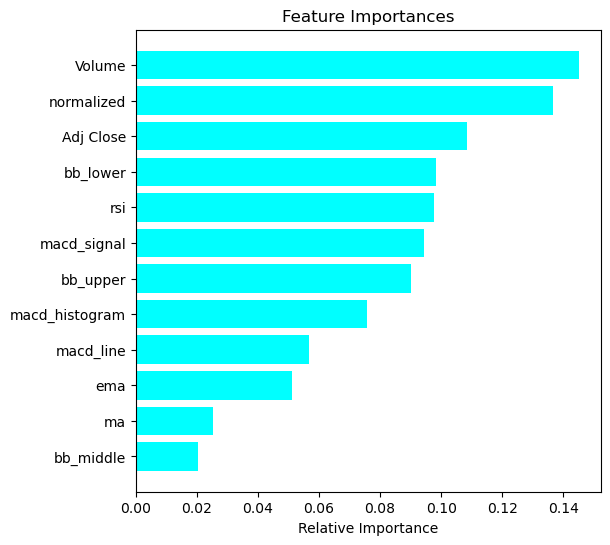

In [15]:
# Initialize decision tree classifier and fit decision tree on the dataset
dtreefeat = DecisionTreeClassifier(class_weight=class_weight2)
dtreefeat.fit(X,Y)

# Get feature importance score and sort descending for plot
importance = dtreefeat.feature_importances_
sort = np.argsort(importance)

# Plot bar chart of feature importance
features = X.columns
plt.figure(figsize=(6,6))
plt.title('Feature Importances')
plt.barh(range(len(sort)), importance[sort], color='cyan', align='center')
plt.yticks(range(len(sort)), [features[i] for i in sort])
plt.xlabel('Relative Importance')
plt.show()

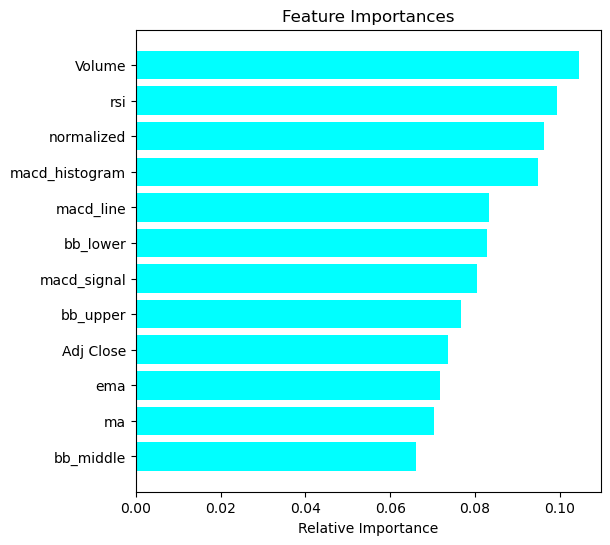

In [27]:
randffeat = RandomForestClassifier(class_weight = class_weight2)
randffeat.fit(X,Y)
features = X.columns
importance = randffeat.feature_importances_
sort = np.argsort(importance)

plt.figure(figsize=(6,6))
plt.title('Feature Importances')
plt.barh(range(len(sort)), importance[sort], color='cyan', align='center')
plt.yticks(range(len(sort)), [features[i] for i in sort])
plt.xlabel('Relative Importance')
plt.show()

**PCA**

In [16]:
# Scaling the data for PCA
X_scaled = X.apply(zscore)
X_scaled

,Adj Close,Volume,normalized,rsi,ma,ema,macd_line,macd_histogram,macd_signal,bb_upper,bb_middle,bb_lower
2020-07-10,0.731885,1.359254,2.033642,3.049273,-0.177803,-0.106787,3.081538,1.876514,2.631103,-0.626636,-0.177803,0.273893
2020-07-14,0.516246,2.559048,2.058320,2.247063,-0.113664,-0.045153,3.087160,1.520664,2.752429,-0.574725,-0.113664,0.347777
2020-07-15,0.376584,1.567408,1.949734,1.781910,-0.065058,-0.003143,2.968732,0.914296,2.824587,-0.525483,-0.065058,0.393945
2020-07-16,0.359909,1.983375,2.072031,1.727408,-0.015447,0.033225,2.831078,0.379345,2.853370,-0.457559,-0.015447,0.423553
2020-07-23,0.335092,1.476697,-7.804896,1.643663,0.034587,0.063686,2.674858,-0.096763,2.843549,-0.369138,0.034587,0.433662
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.502862,-1.163286,0.883619,1.287089,0.307041,0.316660,0.846369,0.310551,0.789093,0.467916,0.307041,0.136104
2023-12-22,0.487247,-1.397816,1.275734,1.205120,0.319751,0.335109,0.853494,0.271791,0.809155,0.466348,0.319751,0.162499
2023-12-26,0.486875,-1.549445,1.067337,1.203092,0.330558,0.351765,0.848469,0.209275,0.824148,0.464465,0.330558,0.185489
2023-12-27,0.484273,-1.330656,-0.177562,1.188181,0.342563,0.366578,0.832592,0.131121,0.832804,0.467903,0.342563,0.205546


In [18]:
train = int(X.shape[0]*0.7)
print(train)

583


In [19]:
# Splitting the data into training and test datasets
x_train = X[:train]
x_test = X[train:]
y_train = Y[:train]
y_test = Y[train:]

In [20]:
x_train.shape, x_test.shape,y_train.shape, y_test.shape

((583, 12), (250, 12), (583,), (250,))

In [21]:
# Getting the predictors and the target data from the master dataset
labels = ["target","Close","Open","High","Low","next_dayadjclose"]
X = df_stock.copy().drop(labels=labels,axis=1)
Y = df_stock.copy().pop('target')

# Splitting the data into training and test datasets
train = int(X.shape[0]*0.7)
x_train = X[:train]
x_test = X[train:]
y_train = Y[:train]
y_test = Y[train:]

### PCA

In [25]:
xtrain_scaled = x_train.apply(zscore)
xtest_scaled = x_test.apply(zscore)
xtrain_scaled.head()

,Adj Close,Volume,normalized,rsi,ma,ema,macd_line,macd_histogram,macd_signal,bb_upper,bb_middle,bb_lower
2020-07-10,0.447539,1.131347,1.854849,3.213786,-0.591482,-0.514149,2.962478,1.743927,2.536230,-0.975487,-0.591482,-0.132992
2020-07-14,0.220766,2.268514,1.877288,2.422822,-0.519832,-0.445212,2.967607,1.421996,2.646583,-0.921029,-0.519832,-0.045865
2020-07-15,0.073891,1.328636,1.778557,1.964189,-0.465535,-0.398222,2.859554,0.873428,2.712216,-0.869371,-0.465535,0.008578
2020-07-16,0.056355,1.722890,1.889754,1.910452,-0.410114,-0.357545,2.733960,0.389468,2.738396,-0.798113,-0.410114,0.043492
2020-07-23,0.030257,1.242660,-7.090819,1.827881,-0.354221,-0.323474,2.591426,-0.041257,2.729462,-0.705353,-0.354221,0.055414


In [26]:
n_cols = xtrain_scaled.columns.value_counts().sum()
n_cols

12

In [27]:
pca = PCA(n_components=n_cols)
pca.fit(xtrain_scaled)

PCA(n_components=12)

In [28]:
#print("Eigenvalues: {}".format(pca.explained_variance_))
#print("Eigen vectors: {}".format(pca.components_))
print("Data capture: {}".format(pca.explained_variance_ratio_))

Data capture: [5.54619500e-01 1.95299853e-01 9.32784667e-02 7.26474925e-02
 6.86486176e-02 9.53302319e-03 5.62325785e-03 2.62754760e-04
 8.70338027e-05 3.09527527e-33 1.23633302e-33 4.82946992e-36]


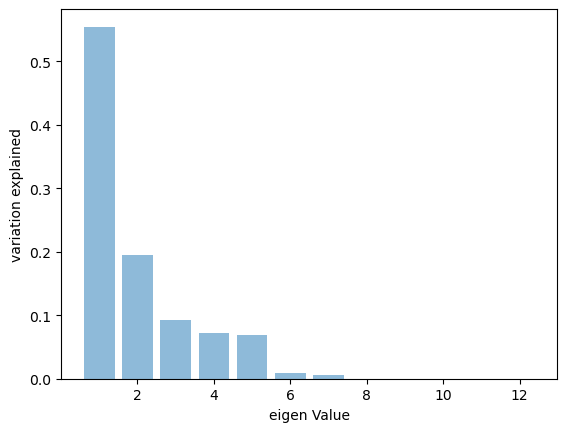

In [29]:
plt.bar(list(range(1,n_cols+1)),pca.explained_variance_ratio_,alpha=0.5,align='center')
plt.ylabel("variation explained")
plt.xlabel("eigen Value")
plt.show()

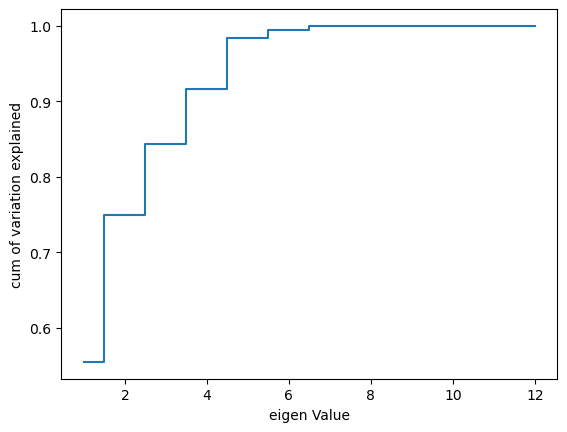

In [30]:
plt.step(list(range(1,n_cols+1)),np.cumsum(pca.explained_variance_ratio_),where='mid')
plt.ylabel("cum of variation explained")
plt.xlabel("eigen Value")
plt.show()

In [31]:
ratios = pca.explained_variance_/np.sum(pca.explained_variance_)
ratios

array([5.54619500e-01, 1.95299853e-01, 9.32784667e-02, 7.26474925e-02,
       6.86486176e-02, 9.53302319e-03, 5.62325785e-03, 2.62754760e-04,
       8.70338027e-05, 3.09527527e-33, 1.23633302e-33, 4.82946992e-36])

In [250]:
threshold = 0.97
indices = np.where(np.cumsum(ratios)>=threshold)[0][0]
indices = 6

In [251]:
pca = PCA(n_components=indices)
pca.fit(xtrain_scaled)
pca.fit(xtest_scaled)
xtrain_pca = pca.transform(xtrain_scaled)
xtest_pca = pca.transform(xtest_scaled)

In [252]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def performance_model(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score
    roc_auc = roc_auc_score(target, pred) #to compute roc_auc

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "roc_auc":roc_auc
        },
        index=[0],
    )

    return df_perf

In [253]:
def myconfusion_matrix(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = metrics.confusion_matrix(y_pred,target,labels=[0,1])
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="",cmap="cividis")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Decision Tree

#### Decision Tree Fitting

In [254]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [255]:
# Fitting the model, Decision Tree
d_tree = DecisionTreeClassifier(random_state = 1,class_weight=class_weight2)
d_tree.fit(xtrain_pca,y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 1.0313588850174216},
                       random_state=1)

Performance on training data:    Accuracy  Recall  Precision   F1  roc_auc
0       1.0     1.0        1.0  1.0      1.0
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.504  0.514706   0.546875  0.530303  0.502967


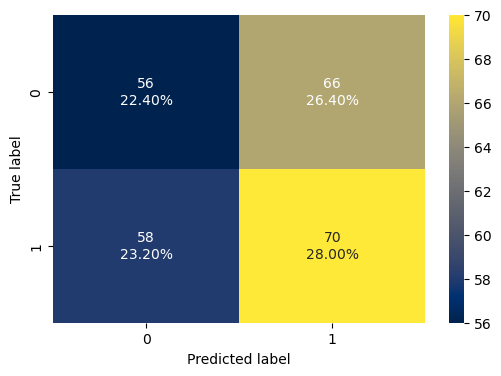

In [256]:
# Checking performance on training data
d_tree_perf_train = performance_model(d_tree,xtrain_pca,y_train)
print("Performance on training data:", d_tree_perf_train)
# Checking performance on test data
d_tree_perf_test = performance_model(d_tree,xtest_pca,y_test)
print("Performance on test data:", d_tree_perf_test)

# Confusion matrix
myconfusion_matrix(d_tree, xtest_pca, y_test)

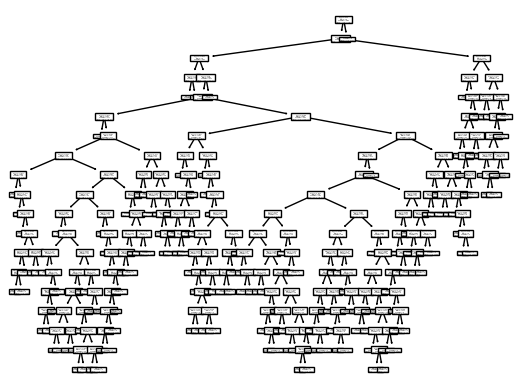

In [257]:
tree.plot_tree(d_tree);

#### Decision Tree Hyperparameter Tuning


In [258]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [259]:
# Intializing the decision tree classifier
dtree_tuned = DecisionTreeClassifier(random_state=1,class_weight=class_weight2)

# Hyperparameter grid
parameters = {'max_depth':np.arange(2,30,1), 
              'min_samples_leaf':np.arange(1,30,1)
             }

# Type of scoring used in selecting the best model during randomsearchcv
scorer = metrics.make_scorer(metrics.f1_score)

# Time series split for temporal order retention
tscv = TimeSeriesSplit(n_splits = 5)

# Run the random search
rand_obj = RandomizedSearchCV(dtree_tuned, parameters, n_iter = 100, scoring=scorer,n_jobs=-1,cv=tscv)
rand_obj = rand_obj.fit(xtrain_pca, y_train)

# Setting the decision tree to the best estimator from the randomsearch
dtree_tuned= rand_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_tuned.fit(xtrain_pca, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 1.0313588850174216}, max_depth=2,
                       min_samples_leaf=5, random_state=1)

It is important to note that model tuning was done using the Randomized Search Cross Validation class of the scikit learn library. The cross validation was done using a timeseries split of 5 across all models.

This was done to preserve the temporal order of the data and maintain uniformity across all models. Failure to do this would have constituted model failure for time series data as future values would have been used to predict the past causing leakage in the model.

Performance on training data:    Accuracy    Recall  Precision        F1  roc_auc
0  0.526587  0.937282   0.510436  0.660934  0.53283
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.556  0.941176   0.554113  0.697548  0.518834


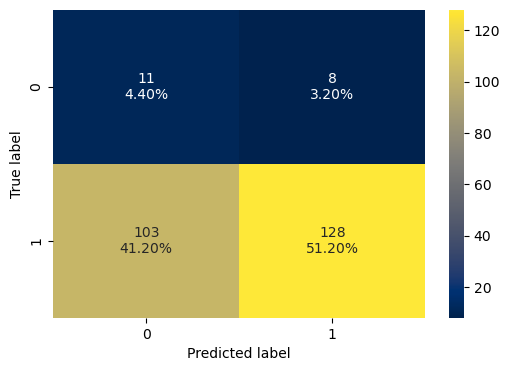

In [260]:
# Checking performance on training data
dtree_tuned_perf_train = performance_model(dtree_tuned,xtrain_pca,y_train)
print("Performance on training data:", dtree_tuned_perf_train)
# Checking performance on test data
dtree_tuned_perf_test = performance_model(dtree_tuned,xtest_pca,y_test)
print("Performance on test data:", dtree_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(dtree_tuned, xtest_pca, y_test)

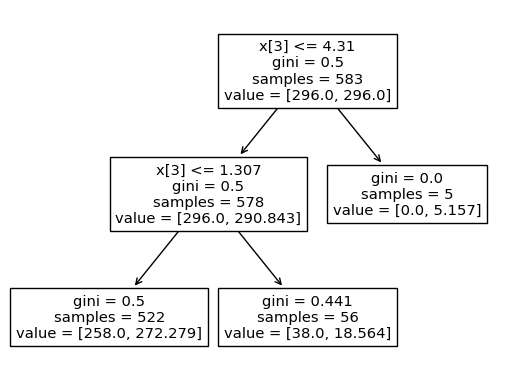

In [261]:
tree.plot_tree(dtree_tuned);

### RandomForest

#### RandomForest fitting

In [262]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [263]:
random_forest = RandomForestClassifier(random_state=1,bootstrap=False,class_weight=class_weight2)
random_forest.fit(xtrain_pca,y_train)

RandomForestClassifier(bootstrap=False,
                       class_weight={0: 1, 1: 1.0313588850174216},
                       random_state=1)

Performance on training data:    Accuracy  Recall  Precision   F1  roc_auc
0       1.0     1.0        1.0  1.0      1.0
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.552  0.551471   0.595238  0.572519  0.552051


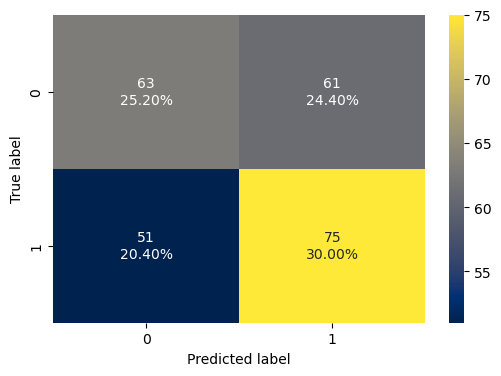

In [264]:
# checking performance on training data
random_forest_perf_train = performance_model(random_forest,xtrain_pca,y_train)
print("Performance on training data:", random_forest_perf_train)
# Checking performance on test data
random_forest_perf_test = performance_model(random_forest,xtest_pca,y_test)
print("Performance on test data:", random_forest_perf_test)

# Confusion matrix
myconfusion_matrix(random_forest, xtest_pca, y_test)

#### RandomForest Hyperparameter Tuning

#### Gridsearch CV

In [265]:
# Intializing the random forest classifier
random_forest_tuned = RandomForestClassifier(random_state=1,oob_score=False,bootstrap=False,class_weight=class_weight2)

# Hyperparameter Grid
parameters = {  'max_depth': list(np.arange(5,100,1)),
                'min_samples_leaf': np.arange(1,100,1),
                'min_samples_split': np.arange(2, 100, 1),
                'n_estimators': np.arange(10,250,1)}


# Type of scoring used in selecting the best model during randomsearchcv
scorer = metrics.make_scorer(metrics.f1_score)

# Time series split for temporal order retention
tscv = TimeSeriesSplit(n_splits = 5)

# Run the random search
rand_obj = RandomizedSearchCV(random_forest_tuned, parameters,n_iter=100, scoring=scorer, cv=tscv,n_jobs=-1)
rand_obj = rand_obj.fit(xtrain_pca, y_train)

# Setting the random forest classifier to the best estimator from the randomsearch
random_forest_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data. 
random_forest_tuned.fit(xtrain_pca, y_train)

RandomForestClassifier(bootstrap=False,
                       class_weight={0: 1, 1: 1.0313588850174216}, max_depth=69,
                       min_samples_leaf=98, min_samples_split=33,
                       n_estimators=181, random_state=1)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.610635  0.630662   0.599338  0.614601  0.610939
Performance on test data:    Accuracy    Recall  Precision        F1  roc_auc
0     0.536  0.448529   0.598039  0.512605  0.54444


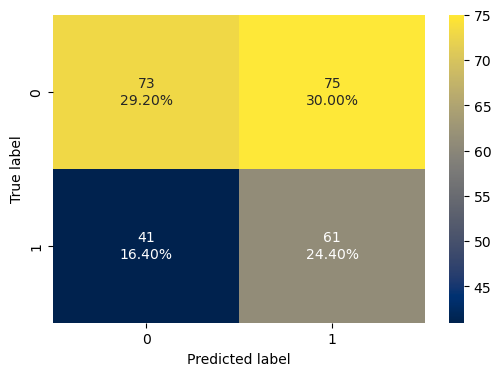

In [266]:
# checking performance on training data
ranodm_forest_tuned_perf_train = performance_model(random_forest_tuned,xtrain_pca,y_train)
print("Performance on training data:", ranodm_forest_tuned_perf_train)
# Checking performance on test data
ranodm_forest_tuned_perf_test = performance_model(random_forest_tuned,xtest_pca,y_test)
print("Performance on test data:", ranodm_forest_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(random_forest_tuned, xtest_pca, y_test)

### Boosting - Model Building and Hyperparameter Tuning

#### AdaBoost Classifier

In [267]:
#Fitting the model
ada = AdaBoostClassifier(random_state=1)
ada.fit(xtrain_pca,y_train)

AdaBoostClassifier(random_state=1)

Performance on training data:    Accuracy    Recall  Precision        F1  roc_auc
0  0.720412  0.703833   0.721429  0.712522  0.72016
Performance on test data:    Accuracy    Recall  Precision        F1  roc_auc
0     0.536  0.595588   0.570423  0.582734  0.53025


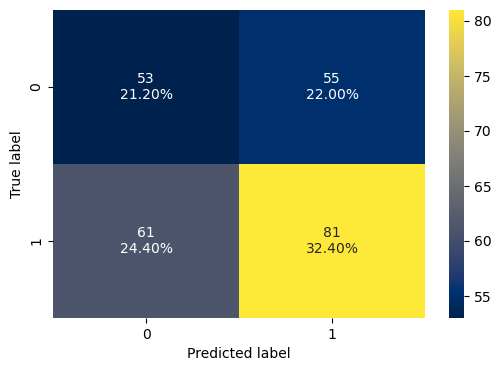

In [268]:
# checking performance on training data
ada_perf_train = performance_model(ada,xtrain_pca,y_train)
print("Performance on training data:", ada_perf_train)
# Checking performance on test data
ada_perf_test = performance_model(ada,xtest_pca,y_test)
print("Performance on test data:", ada_perf_test)

# Confusion matrix
myconfusion_matrix(ada, xtest_pca, y_test)

#### AdaBoost Classifier Hyperparameter tuning

In [269]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [270]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [271]:
# Initializing the AdaBoost Classifier
ada_tuned = AdaBoostClassifier(random_state=1)

# Hyperparameter Grid
parameters = {"estimator":[DecisionTreeClassifier(random_state=1, 
                                                  max_depth = 21,class_weight=class_weight2),
                           LogisticRegression(random_state = 1, class_weight=class_weight2)],
              "n_estimators": np.arange(1,200,1),
              "learning_rate":np.arange(0.1,1,0.1)
}

# Type of scoring used in selecting the best model durning randomsearchcv
scorer = metrics.make_scorer(metrics.f1_score)

# Time series split for temporal order retention
tscv = TimeSeriesSplit(n_splits = 5)

# Run the randomsearch
rand_obj = RandomizedSearchCV(ada_tuned, parameters,n_iter=100,scoring=scorer,cv=tscv)
rand_obj = rand_obj.fit(xtrain_pca, y_train)

# Setting the random forest classifier to the best estimator from the randomsearch
ada_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data.
ada_tuned.fit(xtrain_pca, y_train)

AdaBoostClassifier(estimator=LogisticRegression(class_weight={0: 1,
                                                              1: 1.0313588850174216},
                                                random_state=1),
                   learning_rate=0.1, n_estimators=4, random_state=1)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.516295  0.557491   0.507937  0.531561  0.516921
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0      0.58  0.551471   0.630252  0.588235  0.582753


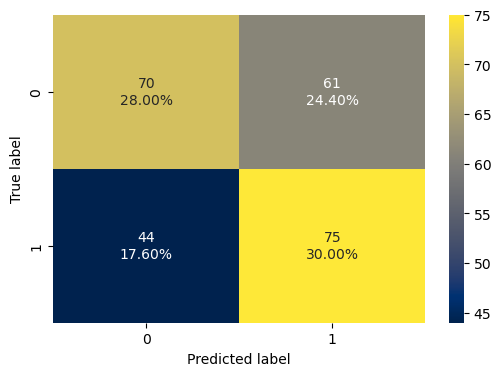

In [272]:
# checking performance on training data
ada_tuned_perf_train = performance_model(ada_tuned,xtrain_pca,y_train)
print("Performance on training data:", ada_tuned_perf_train)
# Checking performance on test data
ada_tuned_perf_test = performance_model(ada_tuned,xtest_pca,y_test)
print("Performance on test data:", ada_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(ada_tuned, xtest_pca, y_test)

#### Gradient Boosting Classifier

In [273]:
#Fitting the model
gb = GradientBoostingClassifier(random_state=1)
gb.fit(xtrain_pca,y_train)

GradientBoostingClassifier(random_state=1)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.909091  0.881533   0.930147  0.905188  0.908672
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0      0.58  0.573529      0.624  0.597701  0.580624


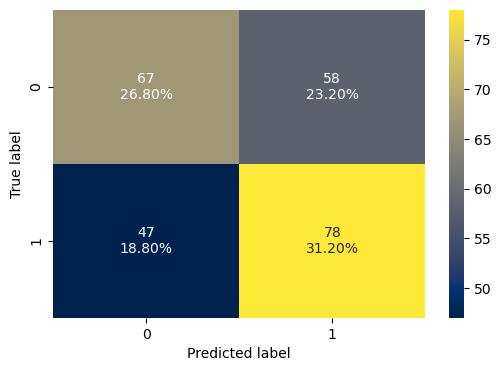

In [274]:
# checking performance on training data
gb_perf_train = performance_model(gb,xtrain_pca,y_train)
print("Performance on training data:", gb_perf_train)
# Checking performance on test data
gb_perf_test = performance_model(gb,xtest_pca,y_test)
print("Performance on test data:", gb_perf_test)

# Confusion matrix
myconfusion_matrix(gb, xtest_pca, y_test)

#### Gradient Boosting with Hyperparameter tuning

In [275]:
# Intializing the GradientBoosting classifier
gb_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1,learning_rate=1,n_estimators=160),
                                      random_state=1)

# Hyperparameter Grid
parameters = {
    "n_estimators":np.arange(10,250,1),
    "max_depth":np.arange(1,4,1),
    "learning_rate":np.arange(0.1,1,0.1)    
}

# Type of scoring used in selecting the best model during randomsearchcv
scorer = metrics.make_scorer(metrics.f1_score)

# Time series split for temporal order retention
tscv = TimeSeriesSplit(n_splits = 5)

# Run the random search
rand_obj = RandomizedSearchCV(gb_tuned, parameters,n_iter=100, scoring=scorer,cv=tscv)
rand_obj = rand_obj.fit(xtrain_pca, y_train)

# Set the clf to the best combination of parameters
gb_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data.
gb_tuned.fit(xtrain_pca, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(learning_rate=1,
                                                   n_estimators=160,
                                                   random_state=1),
                           max_depth=1, n_estimators=239, random_state=1)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.674099  0.651568    0.67509  0.663121  0.673757
Performance on test data:    Accuracy  Recall  Precision        F1   roc_auc
0     0.584   0.625   0.615942  0.620438  0.580044


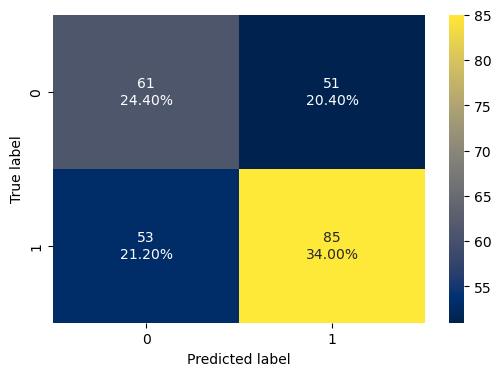

In [276]:
# checking performance on training data
gb_tuned_perf_train = performance_model(gb_tuned,xtrain_pca,y_train)
print("Performance on training data:", gb_tuned_perf_train)
# Checking performance on test data
gb_tuned_perf_test = performance_model(gb_tuned,xtest_pca,y_test)
print("Performance on test data:", gb_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(gb_tuned, xtest_pca, y_test)

#### XGBoost Classifier

In [277]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [278]:
#Fitting the model
xgb = XGBClassifier(random_state=1, eval_metric='logloss')
xgb.fit(xtrain_pca,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

Performance on training data:    Accuracy  Recall  Precision   F1  roc_auc
0       1.0     1.0        1.0  1.0      1.0
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.476  0.411765   0.523364  0.460905  0.482198


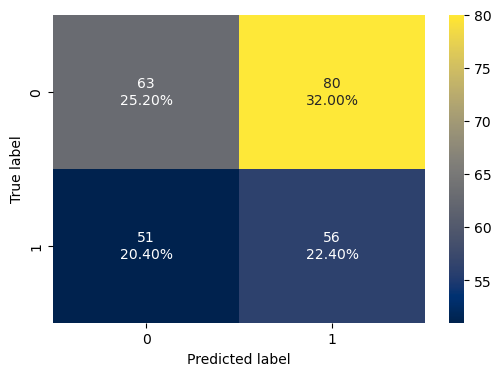

In [279]:
# checking performance on training data
xg_perf_train = performance_model(xgb,xtrain_pca,y_train)
print("Performance on training data:", xg_perf_train)
# Checking performance on test data
xg_perf_test = performance_model(xgb,xtest_pca,y_test)
print("Performance on test data:", xg_perf_test)

# Confusion matrix
myconfusion_matrix(xgb, xtest_pca, y_test)

#### XGBoost with hyperparameter tuning

In [280]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [281]:
scale = y_train.value_counts()[0]/y_train.value_counts()[1]

In [282]:
# Initilzing the XGB classifier
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss',scale_pos_weight=scale)

# Hyperparameter Grid
parameters = {
    "n_estimators":np.arange(1,50,5),
    "learning_rate":np.arange(0.1,1,0.1)
}

# Time series split for temporal order retention
tscv = TimeSeriesSplit(n_splits = 5)

# Type of scoring used in selecting the best model during randomsearchcv
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
rand_obj = RandomizedSearchCV(xgb_tuned, parameters,n_iter=100, scoring=scorer,cv=tscv)
rand_obj = rand_obj.fit(xtrain_pca, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(xtrain_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.718696  0.665505   0.737452  0.699634  0.717888
Performance on test data:    Accuracy    Recall  Precision   F1   roc_auc
0      0.52  0.441176   0.576923  0.5  0.527606


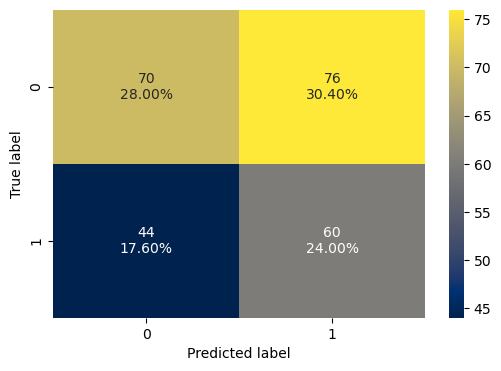

In [283]:
# checking performance on training data
xgb_tuned_perf_train = performance_model(xgb_tuned,xtrain_pca,y_train)
print("Performance on training data:", xgb_tuned_perf_train)
# Checking performance on test data
xgb_tuned_perf_test = performance_model(xgb_tuned,xtest_pca,y_test)
print("Performance on test data:", xgb_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(xgb_tuned, xtest_pca, y_test)

#### Neural Network Classifier

In [284]:
mlp = MLPClassifier(hidden_layer_sizes=(100,50),activation = 'relu')
mlp.fit(xtrain_pca, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50))

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.747856  0.721254   0.755474  0.737968  0.747452
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.516  0.507353   0.560976  0.532819  0.516834


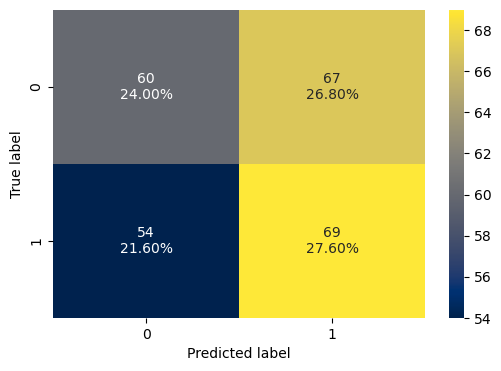

In [285]:
# checking performance on training data
mlp_perf_train = performance_model(mlp,xtrain_pca,y_train)
print("Performance on training data:", mlp_perf_train)
# Checking performance on test data
mlp_perf_test = performance_model(mlp,xtest_pca,y_test)
print("Performance on test data:", mlp_perf_test)

# Confusion matrix
myconfusion_matrix(mlp, xtest_pca, y_test)

In [286]:
MLPClassifier().get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [287]:
# Initializing the MLP classifier
mlp_tuned = MLPClassifier(shuffle=False)

# Hyperparameter Grid
parameters = {
    "max_iter":np.arange(1,200,1),
    "learning_rate":['invscaling', 'constant', 'adaptive'],
    "hidden_layer_sizes":(200,200),
    "activation":['relu','logistic','identity','tanh']
}

# Time series split for temporal order retention
tscv = TimeSeriesSplit(n_splits = 5)

# Type of scoring used in selecting the best model during randomsearchcv
scorer = metrics.make_scorer(metrics.f1_score)

# Run the random search
rand_obj = RandomizedSearchCV(mlp_tuned, parameters,n_iter=300, scoring=scorer,cv=tscv)
rand_obj = rand_obj.fit(xtrain_pca, y_train)


# Set the clf to the best combination of parameters
mlp_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data.
mlp_tuned.fit(xtrain_pca, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=200,
              learning_rate='adaptive', max_iter=29, shuffle=False)

Performance on training data:    Accuracy    Recall  Precision        F1  roc_auc
0  0.493997  0.156794   0.459184  0.233766  0.48887
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.508  0.294118   0.597015  0.394089  0.528638


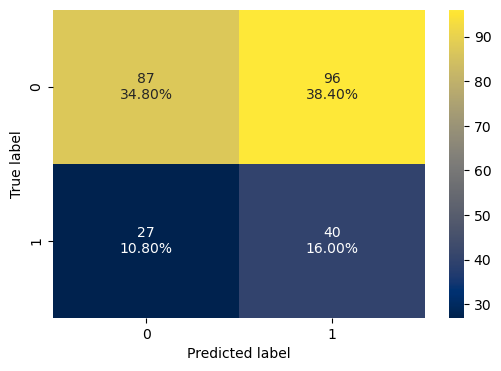

In [288]:
# checking performance on training data
mlp_tuned_perf_train = performance_model(mlp_tuned,xtrain_pca,y_train)
print("Performance on training data:", mlp_tuned_perf_train)
# Checking performance on test data
mlp_tuned_perf_test = performance_model(mlp_tuned,xtest_pca,y_test)
print("Performance on test data:", mlp_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(mlp_tuned, xtest_pca, y_test)

In [289]:
svc = SVC(kernel='rbf', C=1.0,class_weight=class_weight2)
svc.fit(xtrain_pca,y_train)

SVC(class_weight={0: 1, 1: 1.0313588850174216})

Performance on training data:    Accuracy    Recall  Precision        F1  roc_auc
0  0.600343  0.637631   0.586538  0.611018  0.60091
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.548  0.647059   0.575163  0.608997  0.538442


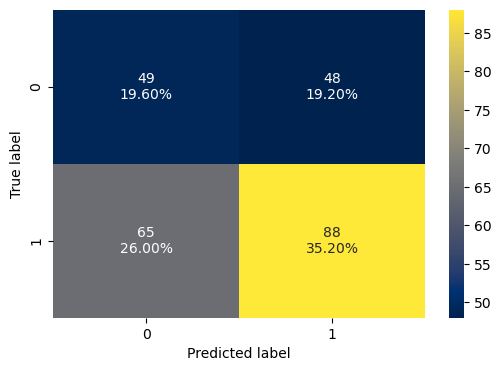

In [290]:
# checking performance on training data
svc_perf_train = performance_model(svc,xtrain_pca,y_train)
print("Performance on training data:", svc_perf_train)
# Checking performance on test data
svc_perf_test = performance_model(svc,xtest_pca,y_test)
print("Performance on test data:", svc_perf_test)

# Confusion matrix
myconfusion_matrix(svc, xtest_pca, y_test)

In [291]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [292]:
# Initializing the SVC classifier
svc_tuned = SVC(random_state = 1,class_weight=class_weight2)

# Hyperparameter Grid
parameters = {
    "C":np.arange(1,10,1),
    "gamma":['auto','scale'],
    "kernel":['poly', 'rbf','sigmoid']
}

# Time series split for temporal order retention
tscv = TimeSeriesSplit(n_splits = 3)

# Type of scoring used in selecting the best model during randomsearchcv
scorer = metrics.make_scorer(metrics.f1_score)

# Run the random search
rand_obj = RandomizedSearchCV(svc_tuned, parameters,n_iter=100, scoring=scorer,cv=tscv)
rand_obj = rand_obj.fit(xtrain_pca, y_train)


# Set the clf to the best combination of parameters
svc_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data.
svc_tuned.fit(xtrain_pca, y_train)

SVC(C=1, class_weight={0: 1, 1: 1.0313588850174216}, kernel='poly',
    random_state=1)

Performance on training data:    Accuracy    Recall  Precision       F1   roc_auc
0  0.545455  0.885017   0.522634  0.65718  0.550617
Performance on test data:    Accuracy    Recall  Precision       F1   roc_auc
0     0.528  0.845588   0.542453  0.66092  0.497356


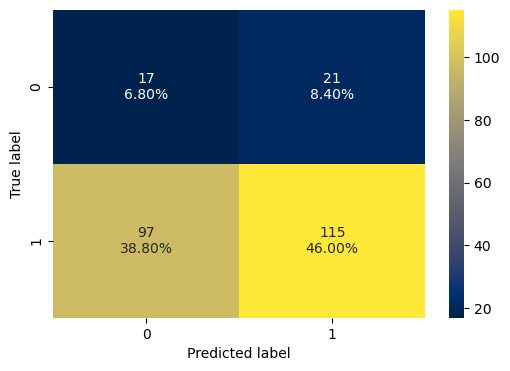

In [293]:
# checking performance on training data
svc_tuned_perf_train = performance_model(svc_tuned,xtrain_pca,y_train)
print("Performance on training data:", svc_tuned_perf_train)
# Checking performance on test data
svc_tuned_perf_test = performance_model(svc_tuned,xtest_pca,y_test)
print("Performance on test data:", svc_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(svc_tuned, xtest_pca, y_test)

### Comparing all Models on Training Data

In [294]:
# training performance comparison

models_train_comp_df = pd.concat([d_tree_perf_train.T,dtree_tuned_perf_train.T,random_forest_perf_train.T,ranodm_forest_tuned_perf_train.T,
ada_perf_train.T, ada_tuned_perf_train.T,gb_perf_train.T,gb_tuned_perf_train.T,xg_perf_train.T,xgb_tuned_perf_train.T,mlp_perf_train.T,
                                  mlp_tuned_perf_train.T,svc_perf_train.T,svc_tuned_perf_train.T],axis=1)
models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest",
    "Random Forest Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "MLP Classifier",
    "MLP Classifier Tuned",
    "SVC Classifier",
    "SVC Classifier Tuned"]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned
Accuracy,1.0,0.526587,1.0,0.610635,0.720412,0.516295,0.909091,0.674099,1.0,0.718696,0.747856,0.493997,0.600343,0.545455
Recall,1.0,0.937282,1.0,0.630662,0.703833,0.557491,0.881533,0.651568,1.0,0.665505,0.721254,0.156794,0.637631,0.885017
Precision,1.0,0.510436,1.0,0.599338,0.721429,0.507937,0.930147,0.675090,1.0,0.737452,0.755474,0.459184,0.586538,0.522634
F1,1.0,0.660934,1.0,0.614601,0.712522,0.531561,0.905188,0.663121,1.0,0.699634,0.737968,0.233766,0.611018,0.657180
roc_auc,1.0,0.532830,1.0,0.610939,0.720160,0.516921,0.908672,0.673757,1.0,0.717888,0.747452,0.488870,0.600910,0.550617


### Comparing all models on Test Data

In [295]:
# testing performance comparison

models_test_comp_df = pd.concat([d_tree_perf_test.T,dtree_tuned_perf_test.T,random_forest_perf_test.T,ranodm_forest_tuned_perf_test.T,
ada_perf_test.T, ada_tuned_perf_test.T,gb_perf_test.T,gb_tuned_perf_test.T,xg_perf_test.T,xgb_tuned_perf_test.T,mlp_perf_test.T,
                                  mlp_tuned_perf_test.T,svc_perf_test.T,svc_tuned_perf_test.T],axis=1)
models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest",
    "Random Forest Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "MLP Classifier",
    "MLP Classifier Tuned",
    "SVC Classifier",
    "SVC Classifier Tuned"]
print("Testing performance comparison:")
models_test_comp_df


Testing performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned
Accuracy,0.504000,0.556000,0.552000,0.536000,0.536000,0.580000,0.580000,0.584000,0.476000,0.520000,0.516000,0.508000,0.548000,0.528000
Recall,0.514706,0.941176,0.551471,0.448529,0.595588,0.551471,0.573529,0.625000,0.411765,0.441176,0.507353,0.294118,0.647059,0.845588
Precision,0.546875,0.554113,0.595238,0.598039,0.570423,0.630252,0.624000,0.615942,0.523364,0.576923,0.560976,0.597015,0.575163,0.542453
F1,0.530303,0.697548,0.572519,0.512605,0.582734,0.588235,0.597701,0.620438,0.460905,0.500000,0.532819,0.394089,0.608997,0.660920
roc_auc,0.502967,0.518834,0.552051,0.544440,0.530250,0.582753,0.580624,0.580044,0.482198,0.527606,0.516834,0.528638,0.538442,0.497356


### Stacking Model

In [296]:
# Define the estimators to be stacked
estimators = [("Decision Tree Tuned",dtree_tuned),
              ('Random Forest Tuned',random_forest_tuned),
              ('AdaBoost',ada),('AdaBoost Tuned',ada_tuned), 
              ('Gradient Boosting Tuned',gb_tuned),
              ('MLP classifier Tuned',mlp_tuned),
              ('SVC Classifier',svc),
              ('SVC Tuned',svc_tuned)]

# Initialize the final estimator
final_estimator = xgb_tuned
stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

# Fit the data on the stacking classifier
stacking_classifier.fit(xtrain_pca,y_train)

StackingClassifier(estimators=[('Decision Tree Tuned',
                                DecisionTreeClassifier(class_weight={0: 1,
                                                                     1: 1.0313588850174216},
                                                       max_depth=2,
                                                       min_samples_leaf=5,
                                                       random_state=1)),
                               ('Random Forest Tuned',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight={0: 1,
                                                                     1: 1.0313588850174216},
                                                       max_depth=69,
                                                       min_samples_leaf=98,
                                                       min_samples_split=33,
                                                       n_estimators=181,
                                                       random_state=1))...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=1, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=1, ...))

Performance on training data:    Accuracy    Recall  Precision   F1   roc_auc
0  0.403087  0.606272   0.425428  0.5  0.406176
Performance on test data:    Accuracy    Recall  Precision        F1  roc_auc
0     0.492  0.669118   0.526012  0.588997  0.47491


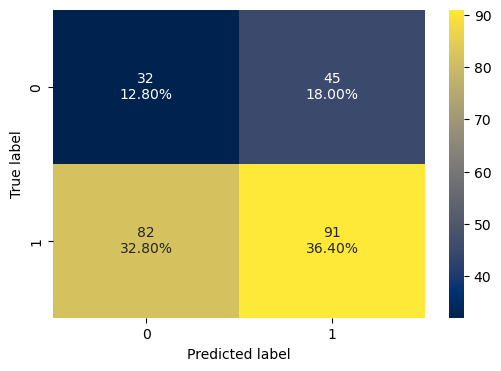

In [297]:
# checking performance on training data
stacking_perf_train = performance_model(stacking_classifier,xtrain_pca,y_train)
print("Performance on training data:", stacking_perf_train)
# Checking performance on test data
stacking_perf_test = performance_model(stacking_classifier,xtest_pca,y_test)
print("Performance on test data:", stacking_perf_test)

# Confusion matrix
myconfusion_matrix(stacking_classifier, xtest_pca, y_test)

### Comparing all Models on Training Data Including the stacked model

In [298]:
# training performance comparison

models_train_comp_df_sent = pd.concat([d_tree_perf_train.T,dtree_tuned_perf_train.T,random_forest_perf_train.T,ranodm_forest_tuned_perf_train.T,
ada_perf_train.T, ada_tuned_perf_train.T,gb_perf_train.T,gb_tuned_perf_train.T,xg_perf_train.T,xgb_tuned_perf_train.T,mlp_perf_train.T,
                                  mlp_tuned_perf_train.T,svc_perf_train.T,svc_tuned_perf_train.T,stacking_perf_train.T],axis=1)
models_train_comp_df_sent.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest",
    "Random Forest Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "MLP Classifier",
    "MLP Classifier Tuned",
    "SVC Classifier",
    "SVC Classifier Tuned",
    "Stacking Classifier"]
print("Training performance comparison:")
models_train_comp_df_sent

Training performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.526587,1.0,0.610635,0.720412,0.516295,0.909091,0.674099,1.0,0.718696,0.747856,0.493997,0.600343,0.545455,0.403087
Recall,1.0,0.937282,1.0,0.630662,0.703833,0.557491,0.881533,0.651568,1.0,0.665505,0.721254,0.156794,0.637631,0.885017,0.606272
Precision,1.0,0.510436,1.0,0.599338,0.721429,0.507937,0.930147,0.675090,1.0,0.737452,0.755474,0.459184,0.586538,0.522634,0.425428
F1,1.0,0.660934,1.0,0.614601,0.712522,0.531561,0.905188,0.663121,1.0,0.699634,0.737968,0.233766,0.611018,0.657180,0.500000
roc_auc,1.0,0.532830,1.0,0.610939,0.720160,0.516921,0.908672,0.673757,1.0,0.717888,0.747452,0.488870,0.600910,0.550617,0.406176


### Comparing all Models on Test Data Including the stacked model

In [299]:
# testing performance comparison

models_test_comp_df_sent = pd.concat([d_tree_perf_test.T,dtree_tuned_perf_test.T,random_forest_perf_test.T,ranodm_forest_tuned_perf_test.T,
ada_perf_test.T, ada_tuned_perf_test.T,gb_perf_test.T,gb_tuned_perf_test.T,xg_perf_test.T,xgb_tuned_perf_test.T,mlp_perf_test.T,
                                  mlp_tuned_perf_test.T,svc_perf_test.T,svc_tuned_perf_test.T,stacking_perf_test.T],axis=1)
models_test_comp_df_sent.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest",
    "Random Forest Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "MLP Classifier",
    "MLP Classifier Tuned",
    "SVC Classifier",
    "SVC Classifier Tuned",
    "Stacking Classifier"]
print("Testing performance comparison:")
models_test_comp_df_sent


Testing performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned,Stacking Classifier
Accuracy,0.504000,0.556000,0.552000,0.536000,0.536000,0.580000,0.580000,0.584000,0.476000,0.520000,0.516000,0.508000,0.548000,0.528000,0.492000
Recall,0.514706,0.941176,0.551471,0.448529,0.595588,0.551471,0.573529,0.625000,0.411765,0.441176,0.507353,0.294118,0.647059,0.845588,0.669118
Precision,0.546875,0.554113,0.595238,0.598039,0.570423,0.630252,0.624000,0.615942,0.523364,0.576923,0.560976,0.597015,0.575163,0.542453,0.526012
F1,0.530303,0.697548,0.572519,0.512605,0.582734,0.588235,0.597701,0.620438,0.460905,0.500000,0.532819,0.394089,0.608997,0.660920,0.588997
roc_auc,0.502967,0.518834,0.552051,0.544440,0.530250,0.582753,0.580624,0.580044,0.482198,0.527606,0.516834,0.528638,0.538442,0.497356,0.474910


In [300]:
models_test_comp_df_sent.loc["F1"].max()
#models_test_comp_df.loc["roc_auc"].max()

0.6975476839237056

### Model Value Assessment

Selecting the svc classifier as the final model, let's compare the predictions against the original dataset

In [301]:
df_stock.head()

,Open,High,Low,Close,Adj Close,Volume,normalized,rsi,ma,ema,macd_line,macd_histogram,macd_signal,bb_upper,bb_middle,bb_lower,next_dayadjclose,target
2020-07-10,159.587997,160.750000,156.785004,160.000000,160.000000,109720000,0.9890,80.010244,135.503526,137.364970,10.810054,1.968032,8.842022,113.314855,135.503526,157.692196,154.199997,0
2020-07-14,154.449997,156.369003,147.500000,154.199997,154.199997,144638000,0.9935,72.439124,137.189075,138.968306,10.829419,1.589917,9.239501,114.699140,137.189075,159.679011,150.443497,0
2020-07-15,154.011505,154.917496,148.658997,150.443497,150.443497,115778000,0.9737,68.049085,138.466400,140.061181,10.421514,0.945611,9.475904,116.012272,138.466400,160.920528,149.994995,0
2020-07-16,148.552994,151.600006,145.911499,149.994995,149.994995,127884000,0.9960,67.534710,139.770150,141.007259,9.947390,0.377189,9.570201,117.823602,139.770150,161.716698,149.327499,0
2020-07-23,154.913498,154.913498,148.500000,149.327499,149.327499,113138000,-0.8050,66.744337,141.085025,141.799662,9.409317,-0.128707,9.538024,120.181498,141.085025,161.988552,150.016495,1


Performance on test data:    Accuracy    Recall  Precision       F1   roc_auc
0     0.528  0.845588   0.542453  0.66092  0.497356


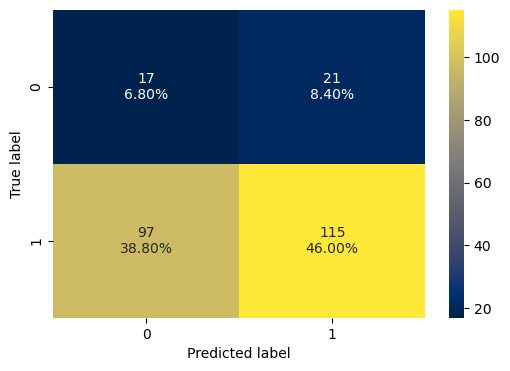

In [302]:
Final = performance_model(svc_tuned,xtest_pca,y_test)
print("Performance on test data:", svc_tuned_perf_test)

myconfusion_matrix(svc_tuned,xtest_pca,y_test)

In [303]:
# Output for Presentation
# Sentiment data

sent_train = models_train_comp_df_sent.T
sent_train.to_csv("sent_train_amzn.csv")

sent_test = models_test_comp_df_sent.T
sent_test.to_csv("sent_test_amzn.csv")
    

# 4. Building the Predictive Model Without Sentiment Data

In [304]:
df_stock

,Open,High,Low,Close,Adj Close,Volume,normalized,rsi,ma,ema,macd_line,macd_histogram,macd_signal,bb_upper,bb_middle,bb_lower,next_dayadjclose,target
2020-07-10,159.587997,160.750000,156.785004,160.000000,160.000000,109720000,0.9890,80.010244,135.503526,137.364970,10.810054,1.968032,8.842022,113.314855,135.503526,157.692196,154.199997,0
2020-07-14,154.449997,156.369003,147.500000,154.199997,154.199997,144638000,0.9935,72.439124,137.189075,138.968306,10.829419,1.589917,9.239501,114.699140,137.189075,159.679011,150.443497,0
2020-07-15,154.011505,154.917496,148.658997,150.443497,150.443497,115778000,0.9737,68.049085,138.466400,140.061181,10.421514,0.945611,9.475904,116.012272,138.466400,160.920528,149.994995,0
2020-07-16,148.552994,151.600006,145.911499,149.994995,149.994995,127884000,0.9960,67.534710,139.770150,141.007259,9.947390,0.377189,9.570201,117.823602,139.770150,161.716698,149.327499,0
2020-07-23,154.913498,154.913498,148.500000,149.327499,149.327499,113138000,-0.8050,66.744337,141.085025,141.799662,9.409317,-0.128707,9.538024,120.181498,141.085025,161.988552,150.016495,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,153.300003,153.970001,152.100006,153.839996,153.839996,36305700,0.7793,63.379051,148.245000,148.380545,3.111417,0.304091,2.807326,142.503087,148.245000,153.986912,153.419998,0
2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100,0.8508,62.605444,148.578999,148.860492,3.135958,0.262905,2.873052,142.461283,148.578999,154.696716,153.410004,0
2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200,0.8128,62.586308,148.863000,149.293779,3.118650,0.196478,2.922172,142.411071,148.863000,155.314929,153.339996,0
2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700,0.5858,62.445576,149.178500,149.679133,3.063965,0.113434,2.950530,142.502726,149.178500,155.854273,153.380005,1


In [305]:
# getting the predictors and the target data
labels = ["target","Close","Open","High","Low","next_dayadjclose","normalized"]
X = df_stock.copy().drop(labels=labels,axis=1)
Y = df_stock.copy().pop('target')
train = int(X.shape[0]*0.7)
print(train)

583


In [306]:
# Splitting the data into training and test datasets
x_train = X[:train]
x_test = X[train:]
y_train = Y[:train]
y_test = Y[train:]

x_train.shape, x_test.shape,y_train.shape, y_test.shape

((583, 11), (250, 11), (583,), (250,))

### PCA

In [307]:
from sklearn.decomposition import PCA
from scipy.stats import zscore
xtrain_scaled = x_train.apply(zscore)
xtest_scaled = x_test.apply(zscore)
xtrain_scaled.head()
n_cols = xtrain_scaled.columns.value_counts().sum()
n_cols
pca = PCA(n_components=n_cols)
pca.fit(xtrain_scaled)

#print("Eigenvalues: {}".format(pca.explained_variance_))
#print("Eigen vectors: {}".format(pca.components_))
print("Data capture: {}".format(pca.explained_variance_ratio_))

Data capture: [5.98859778e-01 2.11125453e-01 9.65277735e-02 7.64955029e-02
 1.03996628e-02 6.20440267e-03 2.91423459e-04 9.60039310e-05
 3.16662397e-33 2.76423080e-33 4.53974072e-35]


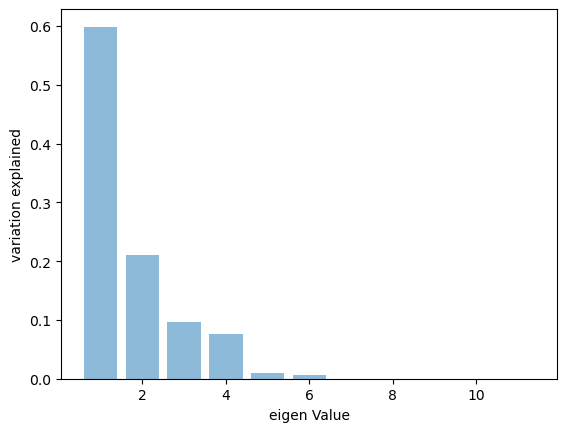

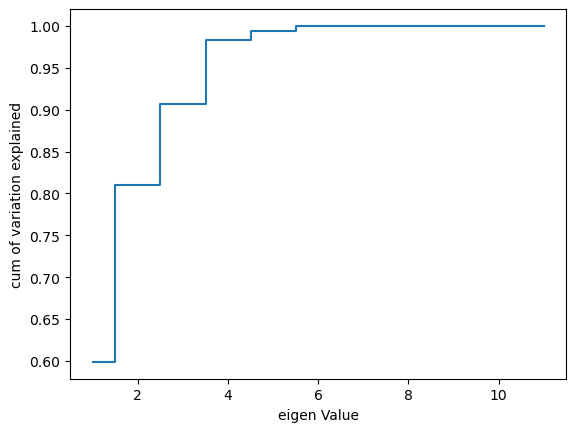

In [308]:
plt.bar(list(range(1,n_cols+1)),pca.explained_variance_ratio_,alpha=0.5,align='center')
plt.ylabel("variation explained")
plt.xlabel("eigen Value")
plt.show()

plt.step(list(range(1,n_cols+1)),np.cumsum(pca.explained_variance_ratio_),where='mid')
plt.ylabel("cum of variation explained")
plt.xlabel("eigen Value")
plt.show()

In [309]:
ratios = pca.explained_variance_/np.sum(pca.explained_variance_)
threshold = 0.97
indices = np.where(np.cumsum(ratios)>threshold)[0][0]

pca = PCA(n_components=indices)
pca.fit(xtrain_scaled)
pca.fit(xtest_scaled)
xtrain_pca = pca.transform(xtrain_scaled)
xtest_pca = pca.transform(xtest_scaled)

In [310]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def performance_model(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score
    roc_auc = roc_auc_score(target, pred) #to compute roc_auc

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "roc_auc":roc_auc
        },
        index=[0],
    )

    return df_perf

def myconfusion_matrix(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = metrics.confusion_matrix(y_pred,target,labels=[0,1])
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="",cmap="cividis")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


### Decision Tree

#### Decision Tree Fitting

In [311]:
# Handling Class Imbalance

# find the minority class
if y_train.value_counts()[0]>y_train.value_counts()[1]:
    classes = y_train.value_counts()[0]/y_train.value_counts()[1]
    class_weight = [{1:classes+0.1,0:1},{1:classes+0.2,0:1},{1:classes+0.3,0:1}]
    class_weight2 = {1:classes,0:1}
else:
    classes = y_train.value_counts()[1]/y_train.value_counts()[0]
    class_weight = [{1:classes+0.1,0:1},{1:classes+0.2,0:1},{1:classes+0.3,0:1}]
    class_weight2 = {1:classes,0:1}
class_weight,class_weight2

([{1: 1.1313588850174217, 0: 1},
  {1: 1.2313588850174215, 0: 1},
  {1: 1.3313588850174216, 0: 1}],
 {1: 1.0313588850174216, 0: 1})

Performance on training data:    Accuracy  Recall  Precision   F1  roc_auc
0       1.0     1.0        1.0  1.0      1.0
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.544  0.573529    0.58209  0.577778  0.541151


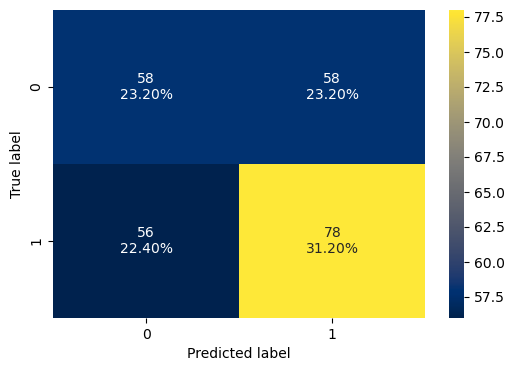

In [312]:
# Fitting the model, Decision Tree
d_tree = DecisionTreeClassifier(random_state = 1,class_weight=class_weight2)
d_tree.fit(xtrain_pca,y_train)

# Checking performance on training data
d_tree_perf_train = performance_model(d_tree,xtrain_pca,y_train)
print("Performance on training data:", d_tree_perf_train)
# Checking performance on test data
d_tree_perf_test = performance_model(d_tree,xtest_pca,y_test)
print("Performance on test data:", d_tree_perf_test)

# Confusion matrix
myconfusion_matrix(d_tree, xtest_pca, y_test)

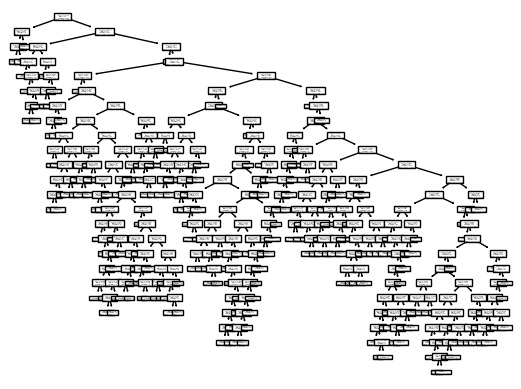

In [313]:
tree.plot_tree(d_tree);

#### Decision Tree Hyperparameter Tuning

In [314]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [315]:
#Choose the type of classifier. 
#dtree_tuned = DecisionTreeClassifier(class_weight={0:0.28,1:0.72},random_state=1)
dtree_tuned = DecisionTreeClassifier(random_state=1,class_weight=class_weight2)

# Grid of parameters to choose from
parameters = {'max_depth':np.arange(2,30,1), 
              'min_samples_leaf':np.arange(1,30,1)
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Time series split for temporal order retention
tscv = TimeSeriesSplit(n_splits = 5)

# Run the grid search
#grid_obj = GridSearchCV(dtree_tuned, parameters, scoring=scorer,n_jobs=-1)
#grid_obj = grid_obj.fit(xtrain_pca, y_train)

# Run the random search
rand_obj = RandomizedSearchCV(dtree_tuned, parameters, n_iter = 100, scoring=scorer,n_jobs=-1,cv=tscv)
rand_obj = rand_obj.fit(xtrain_pca, y_train)

# Set the clf to the best combination of parameters
dtree_tuned= rand_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_tuned.fit(xtrain_pca, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 1.0313588850174216}, max_depth=16,
                       min_samples_leaf=8, random_state=1)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.749571  0.787456   0.726688  0.755853  0.750147
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.552  0.441176      0.625  0.517241  0.562693


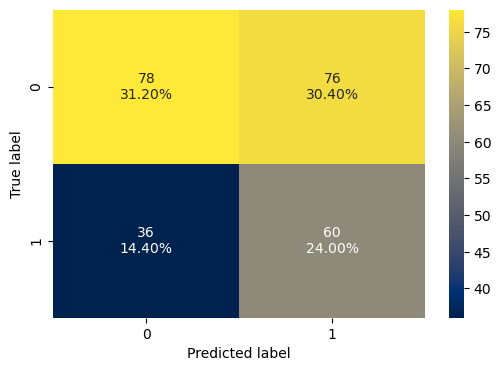

In [316]:
#Checking performance on training data
dtree_tuned_perf_train = performance_model(dtree_tuned,xtrain_pca,y_train)
print("Performance on training data:", dtree_tuned_perf_train)
# Checking performance on test data
dtree_tuned_perf_test = performance_model(dtree_tuned,xtest_pca,y_test)
print("Performance on test data:", dtree_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(dtree_tuned, xtest_pca, y_test)

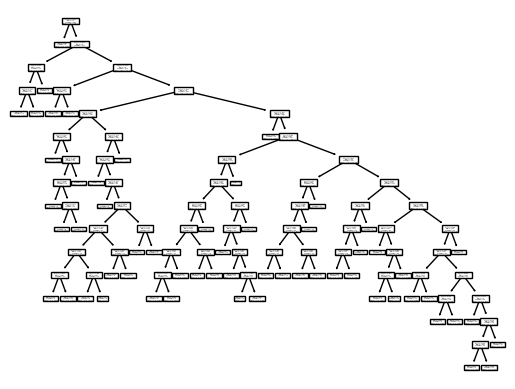

In [317]:
tree.plot_tree(dtree_tuned);

### RandomForest

#### RandomForest fitting

Performance on training data:    Accuracy  Recall  Precision   F1  roc_auc
0       1.0     1.0        1.0  1.0      1.0
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.556  0.514706   0.608696  0.557769  0.559985


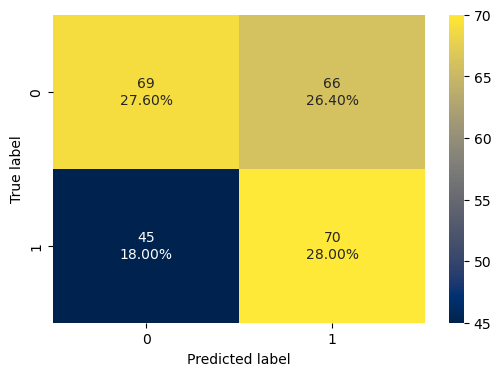

In [318]:
random_forest = RandomForestClassifier(random_state=1,bootstrap=False,class_weight=class_weight2)
random_forest.fit(xtrain_pca,y_train)

# checking performance on training data
random_forest_perf_train = performance_model(random_forest,xtrain_pca,y_train)
print("Performance on training data:", random_forest_perf_train)
# Checking performance on test data
random_forest_perf_test = performance_model(random_forest,xtest_pca,y_test)
print("Performance on test data:", random_forest_perf_test)

# Confusion matrix
myconfusion_matrix(random_forest, xtest_pca, y_test)

#### RandomForest Hyperparameter Tuning

#### Gridsearch CV

In [319]:
# Choose the type of classifier. 
#random_forest_tuned = RandomForestClassifier(class_weight={0:0.18,1:0.82},random_state=1,oob_score=False,bootstrap=False)
random_forest_tuned = RandomForestClassifier(random_state=1,oob_score=False,bootstrap=False,class_weight=class_weight2)

parameters = {  'max_depth': list(np.arange(5,50,1)),
                'min_samples_leaf': np.arange(1,50,1),
                'min_samples_split': np.arange(2, 50, 1),
                'n_estimators': np.arange(10,250,1)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Rolling window cross-validation
tscv = TimeSeriesSplit(n_splits = 5)

# Run the grid search
#grid_obj = GridSearchCV(random_forest_tuned, parameters, scoring=scorer, cv=tscv,n_jobs=-1)
#grid_obj = grid_obj.fit(xtrain_pca, y_train)

# Run the randomized search
rand_obj = RandomizedSearchCV(random_forest_tuned, parameters,n_iter=100, scoring=scorer, cv=tscv,n_jobs=-1)
rand_obj = rand_obj.fit(xtrain_pca, y_train)

# Set the clf to the best combination of parameters
random_forest_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data. 
random_forest_tuned.fit(xtrain_pca, y_train)


RandomForestClassifier(bootstrap=False,
                       class_weight={0: 1, 1: 1.0313588850174216}, max_depth=15,
                       min_samples_leaf=49, min_samples_split=47,
                       n_estimators=114, random_state=1)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.634648  0.672474    0.61859  0.644407  0.635223
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0      0.54  0.448529    0.60396  0.514768  0.548826


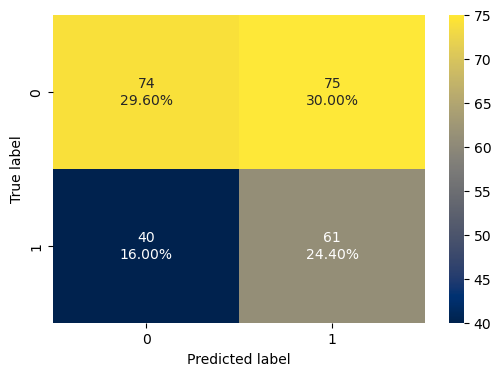

In [320]:
# checking performance on training data
ranodm_forest_tuned_perf_train = performance_model(random_forest_tuned,xtrain_pca,y_train)
print("Performance on training data:", ranodm_forest_tuned_perf_train)
# Checking performance on test data
ranodm_forest_tuned_perf_test = performance_model(random_forest_tuned,xtest_pca,y_test)
print("Performance on test data:", ranodm_forest_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(random_forest_tuned, xtest_pca, y_test)

#### AdaBoost Classifier


In [321]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

Performance on training data:    Accuracy   Recall  Precision        F1   roc_auc
0  0.668954  0.61324   0.682171  0.645872  0.668107
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.524  0.397059   0.593407  0.475771  0.536249


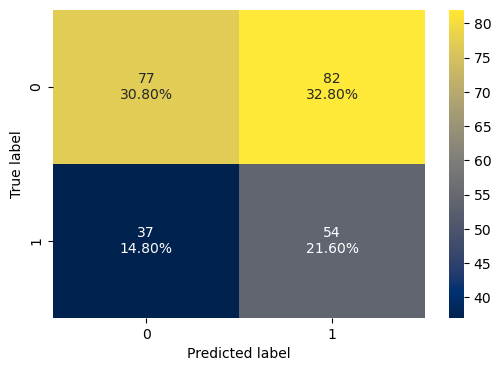

In [322]:
#Fitting the model
ada = AdaBoostClassifier(random_state=1)
ada.fit(xtrain_pca,y_train)

# checking performance on training data
ada_perf_train = performance_model(ada,xtrain_pca,y_train)
print("Performance on training data:", ada_perf_train)
# Checking performance on test data
ada_perf_test = performance_model(ada,xtest_pca,y_test)
print("Performance on test data:", ada_perf_test)

# Confusion matrix
myconfusion_matrix(ada, xtest_pca, y_test)

In [323]:
#### AdaBoost Classifier Hyperparameter tuning

AdaBoostClassifier().get_params()

LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [324]:
# Choose the type of classifier. 
ada_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "estimator":[DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=1,class_weight=class_weight2),LogisticRegression(random_state=1, class_weight=class_weight2)],
    "n_estimators": np.arange(1,200,1),
    "learning_rate":np.arange(0.1,1,0.1)
}

# Rolling window cross-validation
tscv = TimeSeriesSplit(n_splits = 5)

# Type of scoring used to compare parameter  combinations

scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
#grid_obj = GridSearchCV(ada_tuned, parameters, scoring=scorer,cv=20)
#grid_obj = grid_obj.fit(xtrain_pca, y_train)

# Run the grid search
rand_obj = RandomizedSearchCV(ada_tuned, parameters,n_iter=100,scoring=scorer,cv=tscv)
rand_obj = rand_obj.fit(xtrain_pca, y_train)

# Set the clf to the best combination of parameters
ada_tuned = rand_obj.best_estimator_

# Fit the best algorithm to the data.
ada_tuned.fit(xtrain_pca, y_train)


AdaBoostClassifier(estimator=LogisticRegression(class_weight={0: 1,
                                                              1: 1.0313588850174216},
                                                random_state=1),
                   learning_rate=0.5, n_estimators=2, random_state=1)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0   0.51801  0.550523   0.509677  0.529313  0.518505
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.568  0.529412    0.62069  0.571429  0.571723


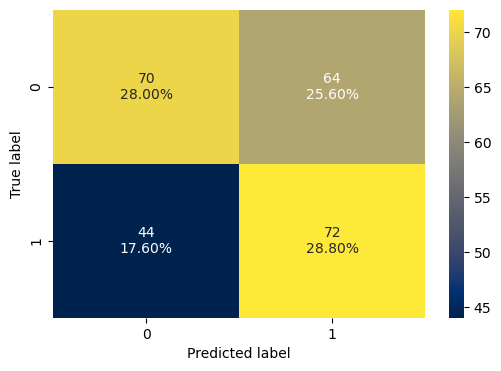

In [325]:
# checking performance on training data
ada_tuned_perf_train = performance_model(ada_tuned,xtrain_pca,y_train)
print("Performance on training data:", ada_tuned_perf_train)
# Checking performance on test data
ada_tuned_perf_test = performance_model(ada_tuned,xtest_pca,y_test)
print("Performance on test data:", ada_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(ada_tuned, xtest_pca, y_test)


Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.886792  0.864111   0.901818  0.882562  0.886448
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.532  0.433824    0.59596  0.502128  0.541473


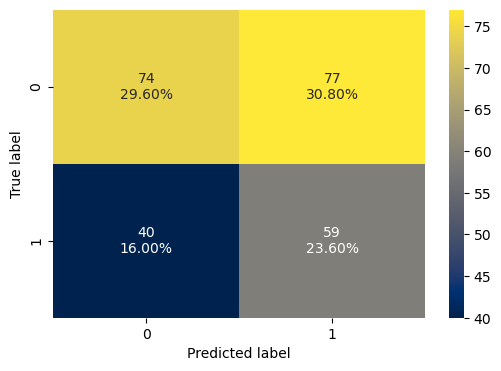

In [326]:
#### Gradient Boosting Classifier

#Fitting the model
gb = GradientBoostingClassifier(random_state=1)
gb.fit(xtrain_pca,y_train)

# checking performance on training data
gb_perf_train = performance_model(gb,xtrain_pca,y_train)
print("Performance on training data:", gb_perf_train)
# Checking performance on test data
gb_perf_test = performance_model(gb,xtest_pca,y_test)
print("Performance on test data:", gb_perf_test)

# Confusion matrix
myconfusion_matrix(gb, xtest_pca, y_test)

In [327]:
#### Gradient Boosting with Hyperparameter tuning

# Choose the type of classifier. 
gb_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1,learning_rate=1,n_estimators=160),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators":np.arange(10,250,1),
    "max_depth":np.arange(1,4,1),
    "learning_rate":np.arange(0.1,1,0.1)
    #'min_samples_split':np.arange(2,20,1)
    
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Rolling window cross-validation
tscv = TimeSeriesSplit(n_splits = 5)

# Run the grid search
#grid_obj = GridSearchCV(gb_tuned, parameters, scoring=scorer,cv=5)
#grid_obj = grid_obj.fit(x_train, y_train)

# Run the grid search
grid_obj = RandomizedSearchCV(gb_tuned, parameters,n_iter=100, scoring=scorer,cv=tscv)
grid_obj = grid_obj.fit(xtrain_pca, y_train)

# Set the clf to the best combination of parameters
gb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gb_tuned.fit(xtrain_pca, y_train)


GradientBoostingClassifier(init=AdaBoostClassifier(learning_rate=1,
                                                   n_estimators=160,
                                                   random_state=1),
                           max_depth=1, n_estimators=13, random_state=1)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.576329  0.404181   0.604167  0.484342  0.573712
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.528  0.404412   0.597826  0.482456  0.539925


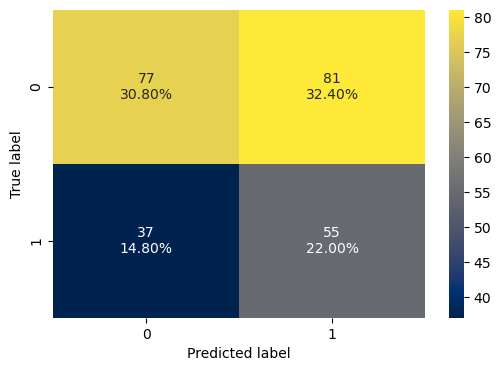

In [328]:
# checking performance on training data
gb_tuned_perf_train = performance_model(gb_tuned,xtrain_pca,y_train)
print("Performance on training data:", gb_tuned_perf_train)
# Checking performance on test data
gb_tuned_perf_test = performance_model(gb_tuned,xtest_pca,y_test)
print("Performance on test data:", gb_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(gb_tuned, xtest_pca, y_test)

In [329]:
#### XGBoost Classifier

XGBClassifier().get_params()

#Fitting the model
xgb = XGBClassifier(random_state=1, eval_metric='logloss')
xgb.fit(xtrain_pca,y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

Performance on training data:    Accuracy  Recall  Precision   F1  roc_auc
0       1.0     1.0        1.0  1.0      1.0
Performance on test data:    Accuracy    Recall  Precision       F1   roc_auc
0     0.524  0.433824   0.584158  0.49789  0.532701


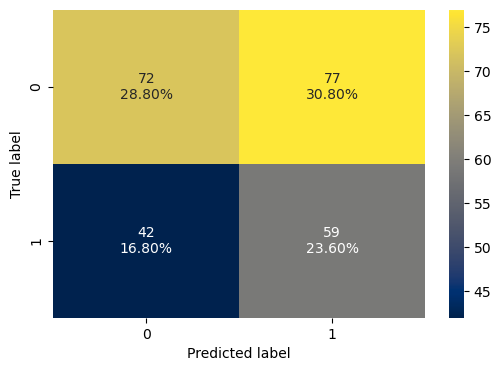

In [330]:
# checking performance on training data
xg_perf_train = performance_model(xgb,xtrain_pca,y_train)
print("Performance on training data:", xg_perf_train)
# Checking performance on test data
xg_perf_test = performance_model(xgb,xtest_pca,y_test)
print("Performance on test data:", xg_perf_test)

# Confusion matrix
myconfusion_matrix(xgb, xtest_pca, y_test)

In [331]:
#### XGBoost with hyperparameter tuning

XGBClassifier().get_params()

# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss',scale_pos_weight=0.5)

# Grid of parameters to choose from
parameters = {
    "n_estimators":np.arange(1,50,5),
    "learning_rate":np.arange(0.1,1,0.1)
}

# Rolling window cross-validation
tscv = TimeSeriesSplit(n_splits = 5)

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
#grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=tscv)
#grid_obj = grid_obj.fit(xtrain_pca, y_train)

# Run the grid search
grid_obj = RandomizedSearchCV(xgb_tuned, parameters,n_iter=100, scoring=scorer,cv=tscv)
grid_obj = grid_obj.fit(xtrain_pca, y_train)


# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(xtrain_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.9, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=16,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0   0.93482  0.867596        1.0  0.929104  0.933798
Performance on test data:    Accuracy    Recall  Precision        F1  roc_auc
0     0.508  0.330882   0.584416  0.422535  0.52509


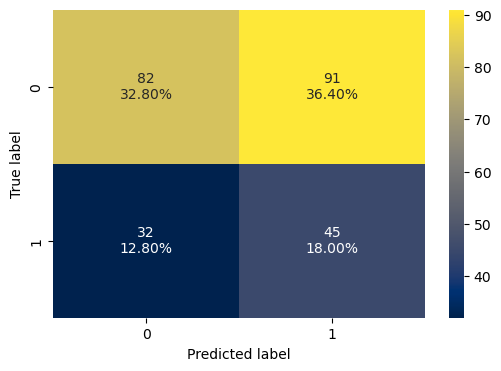

In [332]:
# checking performance on training data
xgb_tuned_perf_train = performance_model(xgb_tuned,xtrain_pca,y_train)
print("Performance on training data:", xgb_tuned_perf_train)
# Checking performance on test data
xgb_tuned_perf_test = performance_model(xgb_tuned,xtest_pca,y_test)
print("Performance on test data:", xgb_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(xgb_tuned, xtest_pca, y_test)

In [333]:
#### Neural Network Classifier

mlp = MLPClassifier(hidden_layer_sizes=(100,50),activation = 'relu')
mlp.fit(xtrain_pca, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50))

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.638079  0.609756   0.638686  0.623886  0.637648
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0     0.548  0.551471   0.590551  0.570342  0.547665


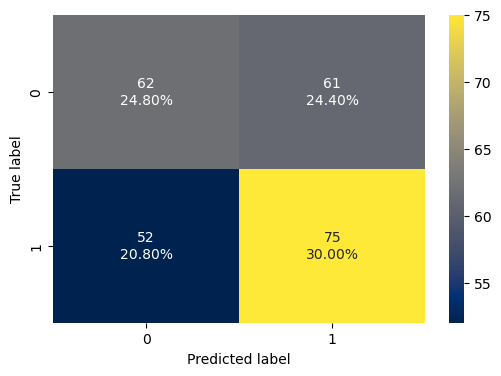

In [334]:
# checking performance on training data
mlp_perf_train = performance_model(mlp,xtrain_pca,y_train)
print("Performance on training data:", mlp_perf_train)
# Checking performance on test data
mlp_perf_test = performance_model(mlp,xtest_pca,y_test)
print("Performance on test data:", mlp_perf_test)

# Confusion matrix
myconfusion_matrix(mlp, xtest_pca, y_test)

In [335]:
MLPClassifier().get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [336]:
# Choose the type of classifier. 
mlp_tuned = MLPClassifier(shuffle=False)

# Grid of parameters to choose from
parameters = {
    "max_iter":np.arange(1,200,1),
    "learning_rate":['invscaling', 'constant', 'adaptive'],
    "hidden_layer_sizes":(200,200),
    "activation":['relu','logistic','identity','tanh']
}

# Rolling window cross-validation
tscv = TimeSeriesSplit(n_splits = 5)

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
#grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=tscv)
#grid_obj = grid_obj.fit(xtrain_pca, y_train)

# Run the grid search
grid_obj = RandomizedSearchCV(mlp_tuned, parameters,n_iter=300, scoring=scorer,cv=tscv)
grid_obj = grid_obj.fit(xtrain_pca, y_train)

# Set the clf to the best combination of parameters
mlp_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
mlp_tuned.fit(xtrain_pca, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=200, max_iter=5,
              shuffle=False)

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.504288  0.083624       0.48  0.142433  0.497893
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0      0.48  0.154412   0.583333  0.244186  0.511416


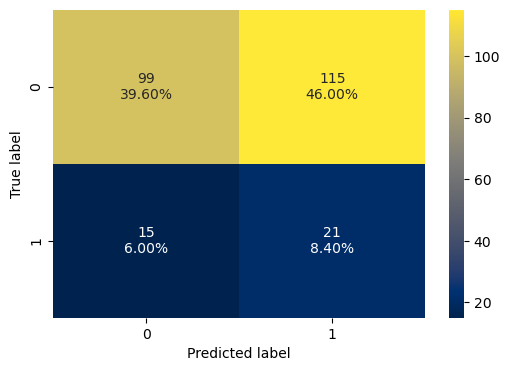

In [337]:
# checking performance on training data
mlp_tuned_perf_train = performance_model(mlp_tuned,xtrain_pca,y_train)
print("Performance on training data:", mlp_tuned_perf_train)
# Checking performance on test data
mlp_tuned_perf_test = performance_model(mlp_tuned,xtest_pca,y_test)
print("Performance on test data:", mlp_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(mlp_tuned, xtest_pca, y_test)

In [338]:
svc = SVC(kernel='rbf', C=1.0,class_weight=class_weight2)
svc.fit(xtrain_pca,y_train)

SVC(class_weight={0: 1, 1: 1.0313588850174216})

Performance on training data:    Accuracy    Recall  Precision       F1   roc_auc
0  0.576329  0.494774   0.581967  0.53484  0.575089
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0      0.54  0.426471   0.610526  0.502165  0.550955


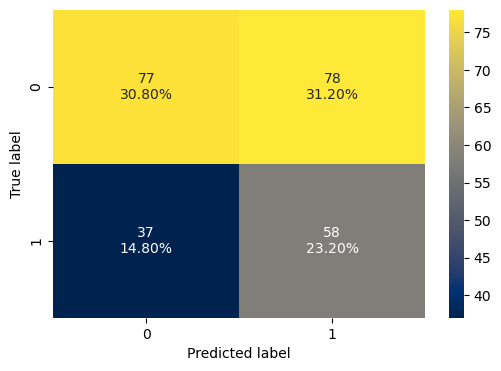

In [339]:
# checking performance on training data
svc_perf_train = performance_model(svc,xtrain_pca,y_train)
print("Performance on training data:", svc_perf_train)
# Checking performance on test data
svc_perf_test = performance_model(svc,xtest_pca,y_test)
print("Performance on test data:", svc_perf_test)

# Confusion matrix
myconfusion_matrix(svc, xtest_pca, y_test)

In [340]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [341]:
# Choose the type of classifier. 
svc_tuned = SVC(shrinking=False,gamma='auto',class_weight=class_weight2)

# Grid of parameters to choose from
parameters = {
    "C":np.arange(1,10,1),
    "kernel":['poly', 'rbf','sigmoid']
}

# Rolling window cross-validation
tscv = TimeSeriesSplit(n_splits = 3)

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
#grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=tscv)
#grid_obj = grid_obj.fit(xtrain_pca, y_train)

# Run the grid search
grid_obj = RandomizedSearchCV(svc_tuned, parameters,n_iter=100, scoring=scorer,cv=tscv)
grid_obj = grid_obj.fit(xtrain_pca, y_train)


# Set the clf to the best combination of parameters
svc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
svc_tuned.fit(xtrain_pca, y_train)

SVC(C=3, class_weight={0: 1, 1: 1.0313588850174216}, gamma='auto',
    kernel='sigmoid', shrinking=False)

Performance on training data:    Accuracy    Recall  Precision       F1  roc_auc
0  0.502573  0.501742   0.494845  0.49827  0.50256
Performance on test data:    Accuracy    Recall  Precision        F1   roc_auc
0      0.48  0.654412   0.517442  0.577922  0.463171


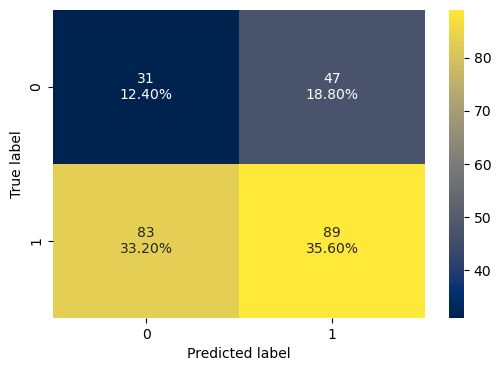

In [342]:
# checking performance on training data
svc_tuned_perf_train = performance_model(svc_tuned,xtrain_pca,y_train)
print("Performance on training data:", svc_tuned_perf_train)
# Checking performance on test data
svc_tuned_perf_test = performance_model(svc_tuned,xtest_pca,y_test)
print("Performance on test data:", svc_tuned_perf_test)

# Confusion matrix
myconfusion_matrix(svc_tuned, xtest_pca, y_test)

### Comparing all Models on Training Data

In [343]:
# training performance comparison

models_train_comp_df_nosent = pd.concat([d_tree_perf_train.T,dtree_tuned_perf_train.T,random_forest_perf_train.T,ranodm_forest_tuned_perf_train.T,
ada_perf_train.T, ada_tuned_perf_train.T,gb_perf_train.T,gb_tuned_perf_train.T,xg_perf_train.T,xgb_tuned_perf_train.T,mlp_perf_train.T,
                                  mlp_tuned_perf_train.T,svc_perf_train.T,svc_tuned_perf_train.T],axis=1)
models_train_comp_df_nosent.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest",
    "Random Forest Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "MLP Classifier",
    "MLP Classifier Tuned",
    "SVC Classifier",
    "SVC Classifier Tuned"]
print("Training performance comparison:")
models_train_comp_df_nosent


Training performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned
Accuracy,1.0,0.749571,1.0,0.634648,0.668954,0.518010,0.886792,0.576329,1.0,0.934820,0.638079,0.504288,0.576329,0.502573
Recall,1.0,0.787456,1.0,0.672474,0.613240,0.550523,0.864111,0.404181,1.0,0.867596,0.609756,0.083624,0.494774,0.501742
Precision,1.0,0.726688,1.0,0.618590,0.682171,0.509677,0.901818,0.604167,1.0,1.000000,0.638686,0.480000,0.581967,0.494845
F1,1.0,0.755853,1.0,0.644407,0.645872,0.529313,0.882562,0.484342,1.0,0.929104,0.623886,0.142433,0.534840,0.498270
roc_auc,1.0,0.750147,1.0,0.635223,0.668107,0.518505,0.886448,0.573712,1.0,0.933798,0.637648,0.497893,0.575089,0.502560


### Comparing all models on Test Data

In [344]:
### Stacking Model
estimators = [("Decision Tree Tuned",dtree_tuned), 
              ('Random Forest Tuned',random_forest_tuned),('AdaBoost',ada),('AdaBoost Tuned',ada_tuned),
              ('MLP Classifier',mlp),
              ('MLP classifier Tuned',mlp_tuned),('SVC Classifier',svc),('SVC Tuned',svc_tuned)]

final_estimator = xgb_tuned

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(xtrain_pca,y_train)

StackingClassifier(estimators=[('Decision Tree Tuned',
                                DecisionTreeClassifier(class_weight={0: 1,
                                                                     1: 1.0313588850174216},
                                                       max_depth=16,
                                                       min_samples_leaf=8,
                                                       random_state=1)),
                               ('Random Forest Tuned',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight={0: 1,
                                                                     1: 1.0313588850174216},
                                                       max_depth=15,
                                                       min_samples_leaf=49,
                                                       min_samples_split=47,
                                                       n_estimators=114,
                                                       random_state=1)...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.9,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=16, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=1, ...))

Performance on training data:    Accuracy    Recall  Precision        F1   roc_auc
0  0.361921  0.337979    0.34767  0.342756  0.361557
Performance on test data:    Accuracy  Recall  Precision        F1  roc_auc
0     0.432   0.375   0.472222  0.418033   0.4375


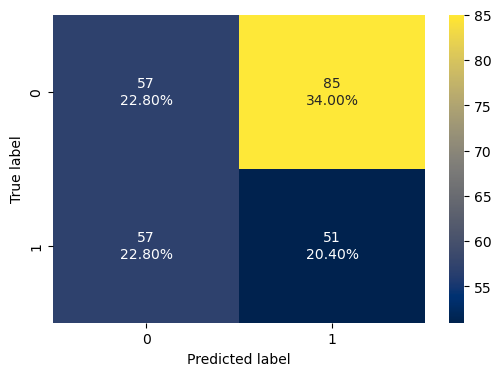

In [345]:
# checking performance on training data
stacking_perf_train = performance_model(stacking_classifier,xtrain_pca,y_train)
print("Performance on training data:", stacking_perf_train)
# Checking performance on test data
stacking_perf_test = performance_model(stacking_classifier,xtest_pca,y_test)
print("Performance on test data:", stacking_perf_test)

# Confusion matrix
myconfusion_matrix(stacking_classifier, xtest_pca, y_test)

In [346]:
### Comparing all Models on Training Data Including the stacked model

# training performance comparison

models_train_comp_df_nosent = pd.concat([d_tree_perf_train.T,dtree_tuned_perf_train.T,random_forest_perf_train.T,ranodm_forest_tuned_perf_train.T,
ada_perf_train.T, ada_tuned_perf_train.T,gb_perf_train.T,gb_tuned_perf_train.T,xg_perf_train.T,xgb_tuned_perf_train.T,mlp_perf_train.T,
                                  mlp_tuned_perf_train.T,svc_perf_train.T,svc_tuned_perf_train.T,stacking_perf_train.T],axis=1)
models_train_comp_df_nosent.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest",
    "Random Forest Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "MLP Classifier",
    "MLP Classifier Tuned",
    "SVC Classifier",
    "SVC Classifier Tuned",
    "Stacking Classifier"]
print("Training performance comparison:")
models_train_comp_df_nosent


Training performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.749571,1.0,0.634648,0.668954,0.518010,0.886792,0.576329,1.0,0.934820,0.638079,0.504288,0.576329,0.502573,0.361921
Recall,1.0,0.787456,1.0,0.672474,0.613240,0.550523,0.864111,0.404181,1.0,0.867596,0.609756,0.083624,0.494774,0.501742,0.337979
Precision,1.0,0.726688,1.0,0.618590,0.682171,0.509677,0.901818,0.604167,1.0,1.000000,0.638686,0.480000,0.581967,0.494845,0.347670
F1,1.0,0.755853,1.0,0.644407,0.645872,0.529313,0.882562,0.484342,1.0,0.929104,0.623886,0.142433,0.534840,0.498270,0.342756
roc_auc,1.0,0.750147,1.0,0.635223,0.668107,0.518505,0.886448,0.573712,1.0,0.933798,0.637648,0.497893,0.575089,0.502560,0.361557


In [347]:
### Comparing all Models on Test Data Including the stacked model

# testing performance comparison

models_test_comp_df_nosent = pd.concat([d_tree_perf_test.T,dtree_tuned_perf_test.T,random_forest_perf_test.T,ranodm_forest_tuned_perf_test.T,
ada_perf_test.T, ada_tuned_perf_test.T,gb_perf_test.T,gb_tuned_perf_test.T,xg_perf_test.T,xgb_tuned_perf_test.T,mlp_perf_test.T,
                                  mlp_tuned_perf_test.T,svc_perf_test.T,svc_tuned_perf_test.T,stacking_perf_test.T],axis=1)
models_test_comp_df_nosent.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest",
    "Random Forest Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "MLP Classifier",
    "MLP Classifier Tuned",
    "SVC Classifier",
    "SVC Classifier Tuned",
    "Stacking Classifier"]
print("Testing performance comparison:")
models_test_comp_df_nosent

Testing performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned,Stacking Classifier
Accuracy,0.544000,0.552000,0.556000,0.540000,0.524000,0.568000,0.532000,0.528000,0.524000,0.508000,0.548000,0.480000,0.540000,0.480000,0.432000
Recall,0.573529,0.441176,0.514706,0.448529,0.397059,0.529412,0.433824,0.404412,0.433824,0.330882,0.551471,0.154412,0.426471,0.654412,0.375000
Precision,0.582090,0.625000,0.608696,0.603960,0.593407,0.620690,0.595960,0.597826,0.584158,0.584416,0.590551,0.583333,0.610526,0.517442,0.472222
F1,0.577778,0.517241,0.557769,0.514768,0.475771,0.571429,0.502128,0.482456,0.497890,0.422535,0.570342,0.244186,0.502165,0.577922,0.418033
roc_auc,0.541151,0.562693,0.559985,0.548826,0.536249,0.571723,0.541473,0.539925,0.532701,0.525090,0.547665,0.511416,0.550955,0.463171,0.437500


# 5. Output

**With Sentiment Data**

In [349]:
# Training Data evaluation
models_train_comp_df_sent

,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.526587,1.0,0.610635,0.720412,0.516295,0.909091,0.674099,1.0,0.718696,0.747856,0.493997,0.600343,0.545455,0.403087
Recall,1.0,0.937282,1.0,0.630662,0.703833,0.557491,0.881533,0.651568,1.0,0.665505,0.721254,0.156794,0.637631,0.885017,0.606272
Precision,1.0,0.510436,1.0,0.599338,0.721429,0.507937,0.930147,0.675090,1.0,0.737452,0.755474,0.459184,0.586538,0.522634,0.425428
F1,1.0,0.660934,1.0,0.614601,0.712522,0.531561,0.905188,0.663121,1.0,0.699634,0.737968,0.233766,0.611018,0.657180,0.500000
roc_auc,1.0,0.532830,1.0,0.610939,0.720160,0.516921,0.908672,0.673757,1.0,0.717888,0.747452,0.488870,0.600910,0.550617,0.406176


In [350]:
# Test Data evaluation
models_test_comp_df_sent

,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned,Stacking Classifier
Accuracy,0.504000,0.556000,0.552000,0.536000,0.536000,0.580000,0.580000,0.584000,0.476000,0.520000,0.516000,0.508000,0.548000,0.528000,0.492000
Recall,0.514706,0.941176,0.551471,0.448529,0.595588,0.551471,0.573529,0.625000,0.411765,0.441176,0.507353,0.294118,0.647059,0.845588,0.669118
Precision,0.546875,0.554113,0.595238,0.598039,0.570423,0.630252,0.624000,0.615942,0.523364,0.576923,0.560976,0.597015,0.575163,0.542453,0.526012
F1,0.530303,0.697548,0.572519,0.512605,0.582734,0.588235,0.597701,0.620438,0.460905,0.500000,0.532819,0.394089,0.608997,0.660920,0.588997
roc_auc,0.502967,0.518834,0.552051,0.544440,0.530250,0.582753,0.580624,0.580044,0.482198,0.527606,0.516834,0.528638,0.538442,0.497356,0.474910


**No sentiment Data**

In [351]:
# Training Data Evaluation
models_train_comp_df_nosent

,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.749571,1.0,0.634648,0.668954,0.518010,0.886792,0.576329,1.0,0.934820,0.638079,0.504288,0.576329,0.502573,0.361921
Recall,1.0,0.787456,1.0,0.672474,0.613240,0.550523,0.864111,0.404181,1.0,0.867596,0.609756,0.083624,0.494774,0.501742,0.337979
Precision,1.0,0.726688,1.0,0.618590,0.682171,0.509677,0.901818,0.604167,1.0,1.000000,0.638686,0.480000,0.581967,0.494845,0.347670
F1,1.0,0.755853,1.0,0.644407,0.645872,0.529313,0.882562,0.484342,1.0,0.929104,0.623886,0.142433,0.534840,0.498270,0.342756
roc_auc,1.0,0.750147,1.0,0.635223,0.668107,0.518505,0.886448,0.573712,1.0,0.933798,0.637648,0.497893,0.575089,0.502560,0.361557


In [352]:
# Test Data Evaluation
models_test_comp_df_nosent

,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,MLP Classifier,MLP Classifier Tuned,SVC Classifier,SVC Classifier Tuned,Stacking Classifier
Accuracy,0.544000,0.552000,0.556000,0.540000,0.524000,0.568000,0.532000,0.528000,0.524000,0.508000,0.548000,0.480000,0.540000,0.480000,0.432000
Recall,0.573529,0.441176,0.514706,0.448529,0.397059,0.529412,0.433824,0.404412,0.433824,0.330882,0.551471,0.154412,0.426471,0.654412,0.375000
Precision,0.582090,0.625000,0.608696,0.603960,0.593407,0.620690,0.595960,0.597826,0.584158,0.584416,0.590551,0.583333,0.610526,0.517442,0.472222
F1,0.577778,0.517241,0.557769,0.514768,0.475771,0.571429,0.502128,0.482456,0.497890,0.422535,0.570342,0.244186,0.502165,0.577922,0.418033
roc_auc,0.541151,0.562693,0.559985,0.548826,0.536249,0.571723,0.541473,0.539925,0.532701,0.525090,0.547665,0.511416,0.550955,0.463171,0.437500


In [353]:
# Output for Presentation
# Sentiment data

sent_train = models_train_comp_df_sent.T
sent_train.to_csv("sent_train_amzn.csv")

sent_test = models_test_comp_df_sent.T
sent_test.to_csv("sent_test_amzn.csv")


In [354]:
# Output for Presentation
# No sentiment data

nosent_train = models_train_comp_df_nosent.T
nosent_train.to_csv("nosent_train_amzn.csv")

nosent_test = models_test_comp_df_nosent.T
nosent_test.to_csv("nosent_test_amzn.csv")


# 6. HIGHLIGHTS

In [357]:
sent_train

,Accuracy,Recall,Precision,F1,roc_auc
Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
Decision Tree Tuned,0.526587,0.937282,0.510436,0.660934,0.532830
Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
Random Forest Tuned,0.610635,0.630662,0.599338,0.614601,0.610939
Adaboost Classifier,0.720412,0.703833,0.721429,0.712522,0.720160
Adabosst Classifier Tuned,0.516295,0.557491,0.507937,0.531561,0.516921
Gradient Boost Classifier,0.909091,0.881533,0.930147,0.905188,0.908672
Gradient Boost Classifier Tuned,0.674099,0.651568,0.675090,0.663121,0.673757
XGBoost Classifier,1.000000,1.000000,1.000000,1.000000,1.000000
XGBoost Classifier Tuned,0.718696,0.665505,0.737452,0.699634,0.717888


In [358]:
sent_test

,Accuracy,Recall,Precision,F1,roc_auc
Decision Tree,0.504,0.514706,0.546875,0.530303,0.502967
Decision Tree Tuned,0.556,0.941176,0.554113,0.697548,0.518834
Random Forest,0.552,0.551471,0.595238,0.572519,0.552051
Random Forest Tuned,0.536,0.448529,0.598039,0.512605,0.544440
Adaboost Classifier,0.536,0.595588,0.570423,0.582734,0.530250
Adabosst Classifier Tuned,0.580,0.551471,0.630252,0.588235,0.582753
Gradient Boost Classifier,0.580,0.573529,0.624000,0.597701,0.580624
Gradient Boost Classifier Tuned,0.584,0.625000,0.615942,0.620438,0.580044
XGBoost Classifier,0.476,0.411765,0.523364,0.460905,0.482198
XGBoost Classifier Tuned,0.520,0.441176,0.576923,0.500000,0.527606


In [388]:
nosent_train

,Accuracy,Recall,Precision,F1,roc_auc
Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
Decision Tree Tuned,0.749571,0.787456,0.726688,0.755853,0.750147
Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
Random Forest Tuned,0.634648,0.672474,0.618590,0.644407,0.635223
Adaboost Classifier,0.668954,0.613240,0.682171,0.645872,0.668107
Adabosst Classifier Tuned,0.518010,0.550523,0.509677,0.529313,0.518505
Gradient Boost Classifier,0.886792,0.864111,0.901818,0.882562,0.886448
Gradient Boost Classifier Tuned,0.576329,0.404181,0.604167,0.484342,0.573712
XGBoost Classifier,1.000000,1.000000,1.000000,1.000000,1.000000
XGBoost Classifier Tuned,0.934820,0.867596,1.000000,0.929104,0.933798


In [389]:
nosent_test

,Accuracy,Recall,Precision,F1,roc_auc
Decision Tree,0.544,0.573529,0.582090,0.577778,0.541151
Decision Tree Tuned,0.552,0.441176,0.625000,0.517241,0.562693
Random Forest,0.556,0.514706,0.608696,0.557769,0.559985
Random Forest Tuned,0.540,0.448529,0.603960,0.514768,0.548826
Adaboost Classifier,0.524,0.397059,0.593407,0.475771,0.536249
Adabosst Classifier Tuned,0.568,0.529412,0.620690,0.571429,0.571723
Gradient Boost Classifier,0.532,0.433824,0.595960,0.502128,0.541473
Gradient Boost Classifier Tuned,0.528,0.404412,0.597826,0.482456,0.539925
XGBoost Classifier,0.524,0.433824,0.584158,0.497890,0.532701
XGBoost Classifier Tuned,0.508,0.330882,0.584416,0.422535,0.525090


**Evaluation Definitions**
> **Overfit Model** - The model overfit the training dataset suggesting noise capture, therefore, performance on test data was unreliable. For this study, overfitting was defined as having an average difference of metric scores between training and test data greater than 15% and less than -15%.

> For this study, we define a **strong learner** as one that performed well on Training data with the average difference of metric scores between the training and test models in the range -15% to 15% and an average metric score higher than 60%

> For this study, we define a **weak learner** as one that performed well on Training data with the average difference of metric scores between the training and test models in the range -15% to 15% and an average metric score lower than 60%

**Sentiment Data**

From the tables above for the training and test data with sentiment data, using the definitions of overfit, strong, and weak learners, we can highlight the following on the model predictions with **sentiment data**

**Overfit Models**
* Decision Tree
* Random Forest
* Adaboost Classifier
* Gradient Boost Classifier
* Gradient Boost Classifier Tuned
* XGBoost Classifier
* MLP Classifier

**Weak Learners**
* Random Forest Tuned
* XGBoost Classifier Tuned
* MLP Classifier Tuned
* SVC Classifier
* Stacking Classifier

**Strong Learners**
* SVC Classifier Tuned
* AdaBoost Classifier Tuned
* Decision Tree Tuned

**Best Model**
* SVC Classifier Tuned

In [390]:
# Table of Strong Learners on sentiment data
learners = sent_test.copy().T
test_sent_strong_learners = learners[["SVC Classifier Tuned"]]
test_sent_strong_learners.head()

,SVC Classifier Tuned
Accuracy,0.528000
Recall,0.845588
Precision,0.542453
F1,0.660920
roc_auc,0.497356


**No sentiment Data**

Using the same tables above and the evaluation definitions defined, we can highlight the following on the model predictions without sentiment data:

**Overfit Models**
* Decision Tree
* Decision Tree Tuned
* Random Forest
* Gradient Boost Classifier
* Gradient Boost Classifier Tuned
* XGBoost Classifier
* XGBoost ClassifierTuned

**Weak Learners**
* Random Forest Tuned
* AdaBoost Classifier
* AdaBoost Classifier Tuned
* MLP Classifier
* MLP Classifier Tuned
* SVC Classifier
* SVC Classifier Tuned
* Stacking Classifier

**Strong Learners**
* None

**Best Model**
* SVC Classifier Tuned

In [412]:
nosent_test

,Accuracy,Recall,Precision,F1,roc_auc
Decision Tree,0.544,0.573529,0.582090,0.577778,0.541151
Decision Tree Tuned,0.552,0.441176,0.625000,0.517241,0.562693
Random Forest,0.556,0.514706,0.608696,0.557769,0.559985
Random Forest Tuned,0.540,0.448529,0.603960,0.514768,0.548826
Adaboost Classifier,0.524,0.397059,0.593407,0.475771,0.536249
Adabosst Classifier Tuned,0.568,0.529412,0.620690,0.571429,0.571723
Gradient Boost Classifier,0.532,0.433824,0.595960,0.502128,0.541473
Gradient Boost Classifier Tuned,0.528,0.404412,0.597826,0.482456,0.539925
XGBoost Classifier,0.524,0.433824,0.584158,0.497890,0.532701
XGBoost Classifier Tuned,0.508,0.330882,0.584416,0.422535,0.525090


In [ ]:
sent_strong_learners = sent_strong_learners.rename(columns = {"SVC Classifier Tuned":"SVC Classifier sent",
                                       "Adabosst Classifier Tuned":"AdaBoost Classifier sent",
                                       "Decision Tree Tuned":"Decision Tree Tuned sent"})

In [416]:
# sentiment data strong learners
sent_strong_learners = learners[["SVC Classifier Tuned", "Adabosst Classifier Tuned","Decision Tree Tuned"]]
nosent_strong_learners = nosent_test.T[["SVC Classifier Tuned", "Adabosst Classifier Tuned","Decision Tree Tuned"]]

In [402]:
sent_strong_learners

,SVC Classifier sent,AdaBoost Classifier sent,Decision Tree Tuned sent
Accuracy,0.528000,0.580000,0.556000
Recall,0.845588,0.551471,0.941176
Precision,0.542453,0.630252,0.554113
F1,0.660920,0.588235,0.697548
roc_auc,0.497356,0.582753,0.518834


In [417]:
nosent_strong_learners

,SVC Classifier Tuned,Adabosst Classifier Tuned,Decision Tree Tuned
Accuracy,0.480000,0.568000,0.552000
Recall,0.654412,0.529412,0.441176
Precision,0.517442,0.620690,0.625000
F1,0.577922,0.571429,0.517241
roc_auc,0.463171,0.571723,0.562693


Among all the classififers used, the SVC classififer had the best performance using F1 score on both datasets with and without sentiment data.

Looking at the scores of the performance metrics across both datasets, for the strong learners and the best model, we can see that the dataset with sentiment data performs better in its predictive ability on the next-day closing direction of the stock. 

For this position to be empirically ratified, this analysis was performed on Netflix Stock, Tesla Stock, S&P500 ETF. This same trend occured across these datasets highlighting the importance of stock news sentiment on the next day performance of the stock.

**Challenges**

This experiment was limited by the availability of data for sentiment analysis. Historical price data was readily available, however, data gathering and scraping news articles for an extended period proved challenging and costly. This inadvertently limited the quantity of data used in the study to a 3-year timeframe and reliance on third party data providers for sentiment data. The cost of data acquisitions also limited the study to securities in the US.